In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

from keras.models import load_model
import tensorflow as tf
from models import GenomeMLP
import hyperparameters as hp
import numpy as np
import shap
print(shap.__version__)

import pickle
import scanpy as sc


from sklearn.calibration import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, f1_score
import pandas as pd
import seaborn as sns


2025-04-14 19:04:13.965297: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-14 19:04:13.996376: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


0.46.0


In [16]:
# condition_mapping = pd.DataFrame({
#     'Original Condition': adata.obs['condition'],
#     'Encoded Condition': adata.obs['encoded_condition']
# }).drop_duplicates().sort_values(by='Encoded Condition')
# print(condition_mapping) 
cluster_decode = {
    0 : "Pyramidal layer2a/b",
    1 : "Pyramidal layer3",
    2 : "Deep Pyramidal",
    3 : "Semilunar",
    4 : "Inhibitory1",
    5 : "Inhibitory2",
    6 : "Contamination1",
    7 : "Contamination2",
    8 : "Pappa2"
}

# condition_mapping.set_index('Encoded Condition', inplace=True)

In [5]:
# # trying to see how big the raw validation is:
# from preprocess import get_data

# training, validation_data, test_data = get_data()
# print(validation_data.shape)

In [6]:
# print(training)
# testing_data = []
# for x, _ in validation_data.as_numpy_iterator():
#     testing_data.append(x)
#     # model.evaluate(x)
# testing_data = np.array(testing_data)
# testing_data.shape

In [4]:
#loading in explainer and all shap values

mods = ["IN_CGE_NPY", "IN_CGE_VIP", "IN_MGE-Pvalb",  "IN_MGE-SST", "Pyrlayer2a/b", "Pyrlayer3", "SL1",  "SL2",  "Vglut2"]

def read_data(time, mod):
    with open(f'../pickles/{time}min-data-{mod}/train_data.pkl', 'rb') as f:
        m30_train = pickle.load(f)
    with open(f'../pickles/{time}min-data-{mod}/train_labels.pkl', 'rb') as f:
        m30_obs_train = pickle.load(f)
    with open(f'../pickles/{time}min-data-{mod}/test_data.pkl', 'rb') as f:
        m30_test = pickle.load(f)
    with open(f'../pickles/{time}min-data-{mod}/test_labels.pkl', 'rb') as f:
        m30_obs_test = pickle.load(f)
    return m30_train, m30_obs_train, m30_test, m30_obs_test
data = {}
for time in ["30", "90"]:
    for i in mods:
        data[time + i] = read_data(time, i)

print(len(data))


18


In [5]:
# reading in the model


# def read_in_model(which_model, layers, dropout):

#     model = GenomeMLP(layers, layers, layers, layers, dropout, dropout)


#     model.model(tf.keras.Input(shape=(hp.num_features, )))
#     model.model(tf.zeros((1, hp.num_features)))

#     model.model.load_weights(f'../{which_model}-model/checkpoint.weights.h5')
#     model.summary()

#     model.build(input_shape=(None, hp.num_features))
#     model.compile(
#         optimizer = "adam", 
#         loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False), 
#         metrics = [["sparse_categorical_accuracy"]]
#     )

#     return model 

def read_in_model(time, ct):
    model = load_model(f"../ct-models/{time}min-{ct}-model.h5")
    model.evaluate(data[time + ct][2].X, data[time + ct][3])

    return model
    

models = {}
for time in ["30", "90"]:
    for i in mods:
        print(time + i)
        models[time + i] = read_in_model(time, i)
    


30IN_CGE_NPY


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7071 - loss: 0.8194


30IN_CGE_VIP
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6919 - loss: 0.9845  


30IN_MGE-Pvalb
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7082 - loss: 0.8276  


30IN_MGE-SST
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6083 - loss: 1.0650  


30Pyrlayer2a/b
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6463 - loss: 1.7833
30Pyrlayer3


108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7586 - loss: 0.7363
30SL1


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7070 - loss: 1.0155
30SL2


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6497 - loss: 1.1265


30Vglut2
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6078 - loss: 0.9995  


90IN_CGE_NPY
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7387 - loss: 0.7322  


90IN_CGE_VIP
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6997 - loss: 0.9112


90IN_MGE-Pvalb
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7463 - loss: 0.7570  


90IN_MGE-SST
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6771 - loss: 0.7344


90Pyrlayer2a/b
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7867 - loss: 1.2831


90Pyrlayer3
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8839 - loss: 0.5468
90SL1


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7860 - loss: 1.0002


90SL2
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7667 - loss: 0.7208
90Vglut2


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7500 - loss: 0.5628  


In [3]:
cross_predict30 = pd.DataFrame(index = ["30"+x for x in mods])
time_mods = ["30"+x for x in mods] + ["90" + x for x in mods]
for i in ["30"+x for x in mods]:
    results = []
    for j in ["30"+x for x in mods]:
        # print(models[time+i])
        # print(data[time+j])
        results.append(np.mean(np.argmax(models[i].predict(data[j][2].X), axis = 1) == data[j][3]))

    cross_predict30[i] = results
cross_predict30.index.name = "Model"
cross_predict30.columns.name = "Sample"

plt.figure(figsize=(12, 10))
sns.heatmap(cross_predict30, annot=True, cmap='Blues', fmt=".2f", linewidths=0.5)

plt.title("30min model cell-type models cross prediction")
plt.show()

# print(cross_predict)
print(time_mods)


cross_predict90 = pd.DataFrame(index = ["90" + x for x in mods])
for i in ["90"+x for x in mods]:
    results = []
    for j in ["90"+x for x in mods]:
        # print(models[time+i])
        # print(data[time+j])
        results.append(np.mean(np.argmax(models[i](data[j][2].X), axis = 1) == data[j][3]))

    cross_predict90[i] = results
cross_predict90.index.name = "Model"
cross_predict90.columns.name = "Sample"

plt.figure(figsize=(12, 10))
sns.heatmap(cross_predict90, annot=True, cmap='Blues', fmt=".2f", linewidths=0.5)

plt.title("90min cell-type models cross prediction")
plt.show()

# print(cross_predict)
print(time_mods)

NameError: name 'models' is not defined

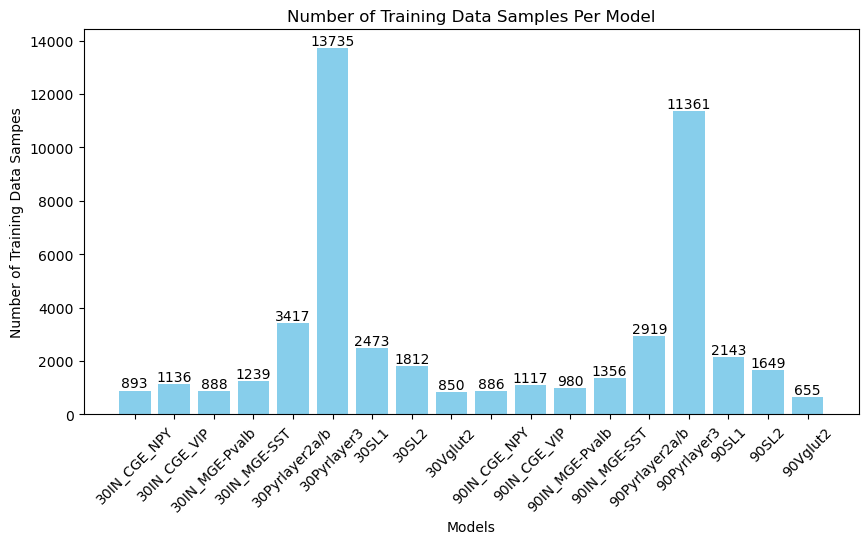

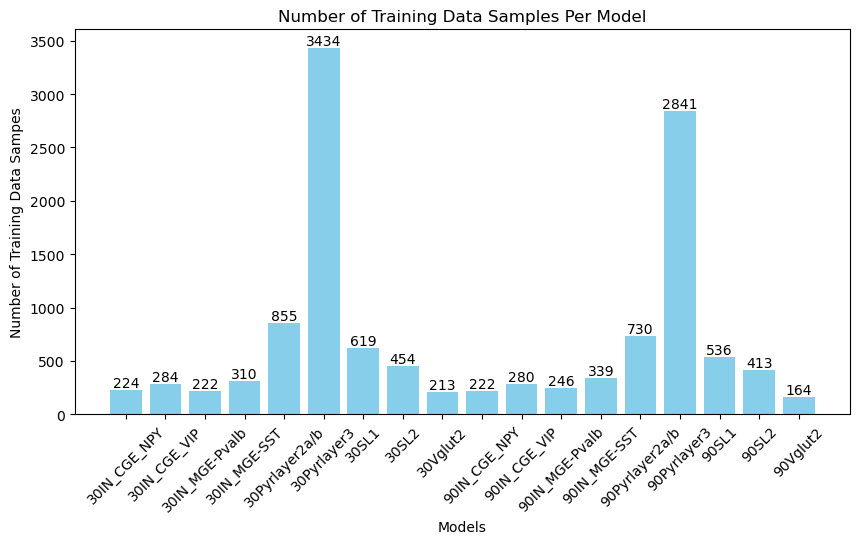

In [6]:
graph = {x: len(data[x][0]) for x in time_mods}

# Create the bar graph
plt.figure(figsize=(10, 5))  # Adjust figure size
bars = plt.bar(graph.keys(), graph.values(), color='skyblue')

# Annotate each bar with its value
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, str(yval), ha='center', va='bottom', fontsize=10)

# Labeling
plt.xlabel("Models")
plt.ylabel("Number of Training Data Sampes")
plt.title("Number of Training Data Samples Per Model")
plt.xticks(rotation=45)  # Rotate x labels for readability

# Show the graph
plt.show()

graph = {x: len(data[x][2]) for x in time_mods}

# Create the bar graph
plt.figure(figsize=(10, 5))  # Adjust figure size
bars = plt.bar(graph.keys(), graph.values(), color='skyblue')

# Annotate each bar with its value
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, str(yval), ha='center', va='bottom', fontsize=10)

# Labeling
plt.xlabel("Models")
plt.ylabel("Number of Training Data Sampes")
plt.title("Number of Training Data Samples Per Model")
plt.xticks(rotation=45)  # Rotate x labels for readability

# Show the graph
plt.show()

In [16]:
# calculating the correlation between accuracy and size of training set
sizes = [len(data[x][0]) for x in time_mods]
accuracies = [np.mean(np.argmax(models[i](data[i][2].X), axis = 1) == data[i][3]) for i in time_mods]

print(sizes)
print(accuracies)


correlation = np.corrcoef(sizes, accuracies)[0, 1]
print(f"Overall Pearson Correlation: {correlation}")



[893, 1136, 888, 1239, 3417, 13735, 2473, 1812, 850, 886, 1117, 980, 1356, 2919, 11361, 2143, 1649, 655]
[0.7008928571428571, 0.6619718309859155, 0.6711711711711712, 0.5935483870967742, 0.6467836257309941, 0.7623762376237624, 0.7075928917609047, 0.6387665198237885, 0.5821596244131455, 0.7252252252252253, 0.7142857142857143, 0.7357723577235772, 0.7109144542772862, 0.8068493150684931, 0.8782118972192889, 0.7910447761194029, 0.7893462469733656, 0.725609756097561]
Overall Pearson Correlation: 0.509023736692077


# Confusion Matrices:

### Aggregate Confusion matrix

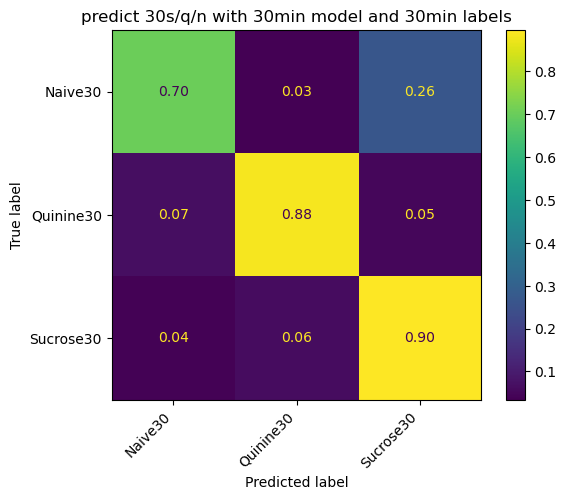

0.3559946416610851
0.3256307211431123
0.3183746371958026


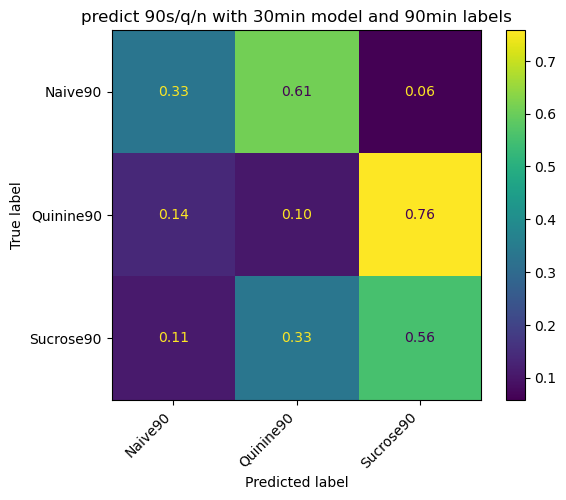

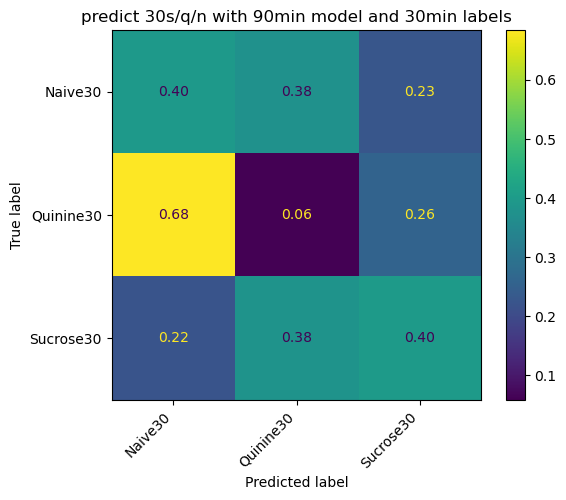

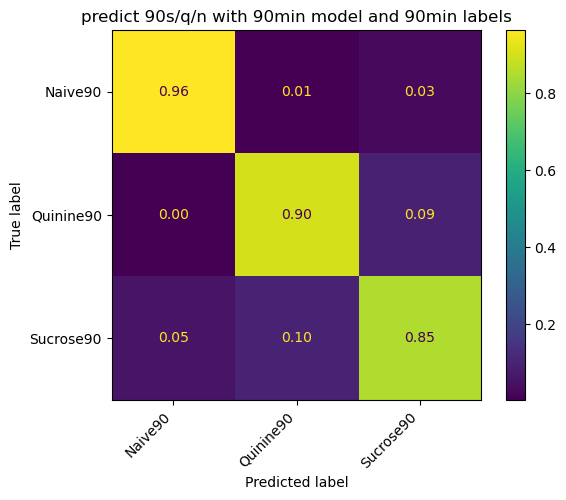

In [33]:

pred30_30 = np.argmax(tf.nn.softmax(model30(m30_test.raw.X.toarray())), axis = 1) 
pred30_90 = np.argmax(tf.nn.softmax(model30(m90_test.raw.X.toarray())), axis = 1) 
label30 = labels = [
'Naive30',
'Quinine30',
'Sucrose30',
]
pred90_30 = np.argmax(tf.nn.softmax(model90(m30_test.raw.X.toarray())), axis = 1)
pred90_90 = np.argmax(tf.nn.softmax(model90(m90_test.raw.X.toarray())), axis = 1) 
label90 = labels = [
'Naive90',
'Quinine90',
'Sucrose90',
]

m30_obs_test
m90_obs_test

def produce_confusion_mat( ground_truth, preds,labels, title):
    confuse_mat = confusion_matrix(ground_truth, preds, normalize = 'true', labels = range(len(labels)))
    mat = ConfusionMatrixDisplay(confusion_matrix=confuse_mat, display_labels=labels)
    
    mat.plot(values_format=".2f")
    
    plt.xticks(rotation=45, ha='right')
    plt.title(title)
    plt.show()
    
produce_confusion_mat( m30_obs_test, pred30_30, label30, "predict 30s/q/n with 30min model and 30min labels")

print(np.sum(m30_obs_test == 0)/len(m30_obs_test))
print(np.sum(m30_obs_test == 1)/len(m30_obs_test))
print(np.sum(m30_obs_test == 2)/len(m30_obs_test))


produce_confusion_mat( m90_obs_test, pred30_90, label90, "predict 90s/q/n with 30min model and 90min labels")
produce_confusion_mat( m30_obs_test, pred90_30, label30, "predict 30s/q/n with 90min model and 30min labels")
produce_confusion_mat( m90_obs_test, pred90_90, label90, "predict 90s/q/n with 90min model and 90min labels")


# print(np.sum(pred30_30 == 1)/len(pred30_30) * np.sum((m30_obs_test == 1) == (pred30_30 == 2)))
# print(np.sum((m30_obs_test == 2) == (pred30_30 == 2)))
# print((m30_obs_test == 2) == (pred30_30 == 2))
# print(np.sum(m30_obs_test == 2))
# print(np.sum(pred30_30 == 2)/len(pred30_30) * np.sum((m30_obs_test == 2) == (pred30_30 == 2))/np.sum(m30_obs_test == 2))

# Original Condition  Encoded Condition
# AAACCCAAGACCTGGA-1-0-adlib30              adlib30                  0  bored 2 = 0
# AAACCCAAGAGAGTGA-1-0-adlib90              adlib90                  1  naive 30 3 = 1
# AAACCCAAGCCTTTGA-1-0-bored                  bored                  2  naive 90 4 = 2
# AAACCCAAGACGCCCT-1-0-naive30              naive30                  3  adlib30 0 = 3
# AAACCCAAGAGGTTTA-1-0-naive90              naive90                  4  adlib90 1 = 4
# AAACCCAAGTTCACTG-1-0-quinine30          quinine30                  5  sucrose30 7 = 5
# AAACCCAAGGAGCAAA-1-0-quinine90          quinine90                  6  sucrose 90 8 = 6
# AAACCCAAGACGCCCT-1-0-sucrose30          sucrose30                  7  quinine30 5 = 7
# AAACCCAAGAGGTCAC-1-0-sucrose90          sucrose90                  8  quinine90 6 = 8

# AAACCCAAGACCTGGA-1-0-adlib30              adlib30                  0 
# AAACCCAAGAGAGTGA-1-0-adlib90              adlib90                  1
# AAACCCAAGCCTTTGA-1-0-bored                  bored                  2
# AAACCCAAGACGCCCT-1-0-naive30              naive30                  3
# AAACCCAAGAGGTTTA-1-0-naive90              naive90                  4
# AAACCCAAGTTCACTG-1-0-quinine30          quinine30                  5
# AAACCCAAGGAGCAAA-1-0-quinine90          quinine90                  6
# AAACCCAAGACGCCCT-1-0-sucrose30          sucrose30                  7
# AAACCCAAGAGGTCAC-1-0-sucrose90          sucrose90                  8

labels = [
'Bored',
'Naive30',
'Naive90',
'Adlib30',
'Adlib90',
'Sucrose30',
'Sucrose90',
'Quinine30',
'Quinine90']

order_conversion = {
    2: 0, 
    3: 1, 
    4: 2,
    0: 3, 
    1: 4, 
    7: 5, 
    8: 6, 
    5: 7, 
    6: 8, 
}


# print(np.mean(np.argmax(model.predict(X_test.raw.X.toarray()), axis=1) == obs_test.tolist()))
# ground_truth = obs_test.tolist()
# # print(ground_truth)

# for i in range(len(ground_truth)):
#     ground_truth[i] = order_conversion[ground_truth[i]]

# preds = np.argmax(tf.nn.softmax(model.predict(X_test.raw.X.toarray())), axis = 1)

# # model.evaluate(X_test.raw.X.toarray(), ground_truth)
# for i in range(len(preds)):
#     preds[i] = order_conversion[preds[i]]
# print(np.mean(preds == ground_truth))


# print(obs_test.shape)
# .35
# .2259

[0.00524934 0.01946678 0.01411879 0.01061853 0.11896552 0.00801603
 0.02913907 0.02566248 0.04871712]


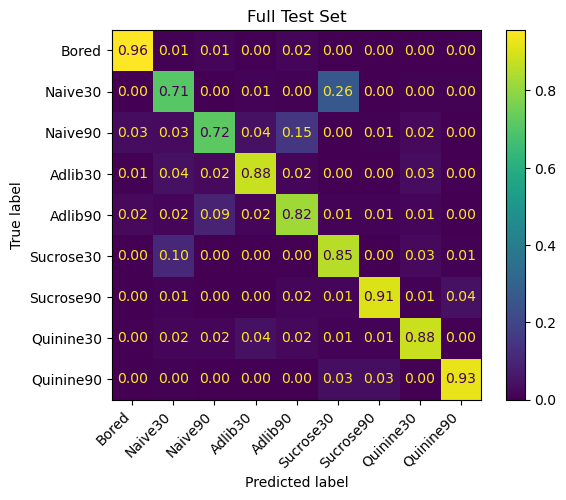

In [20]:
confuse_mat = confusion_matrix(ground_truth, preds, normalize = 'true', labels = range(len(labels)))
print(f1_score(obs_test, preds, average=None))
mat = ConfusionMatrixDisplay(confusion_matrix=confuse_mat, display_labels=labels)

mat.plot(values_format=".2f")

plt.xticks(rotation=45, ha='right')
plt.title("Full Test Set")
plt.show()

### Individual Confusion matrices for each cell type, using Leiden clustering


76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


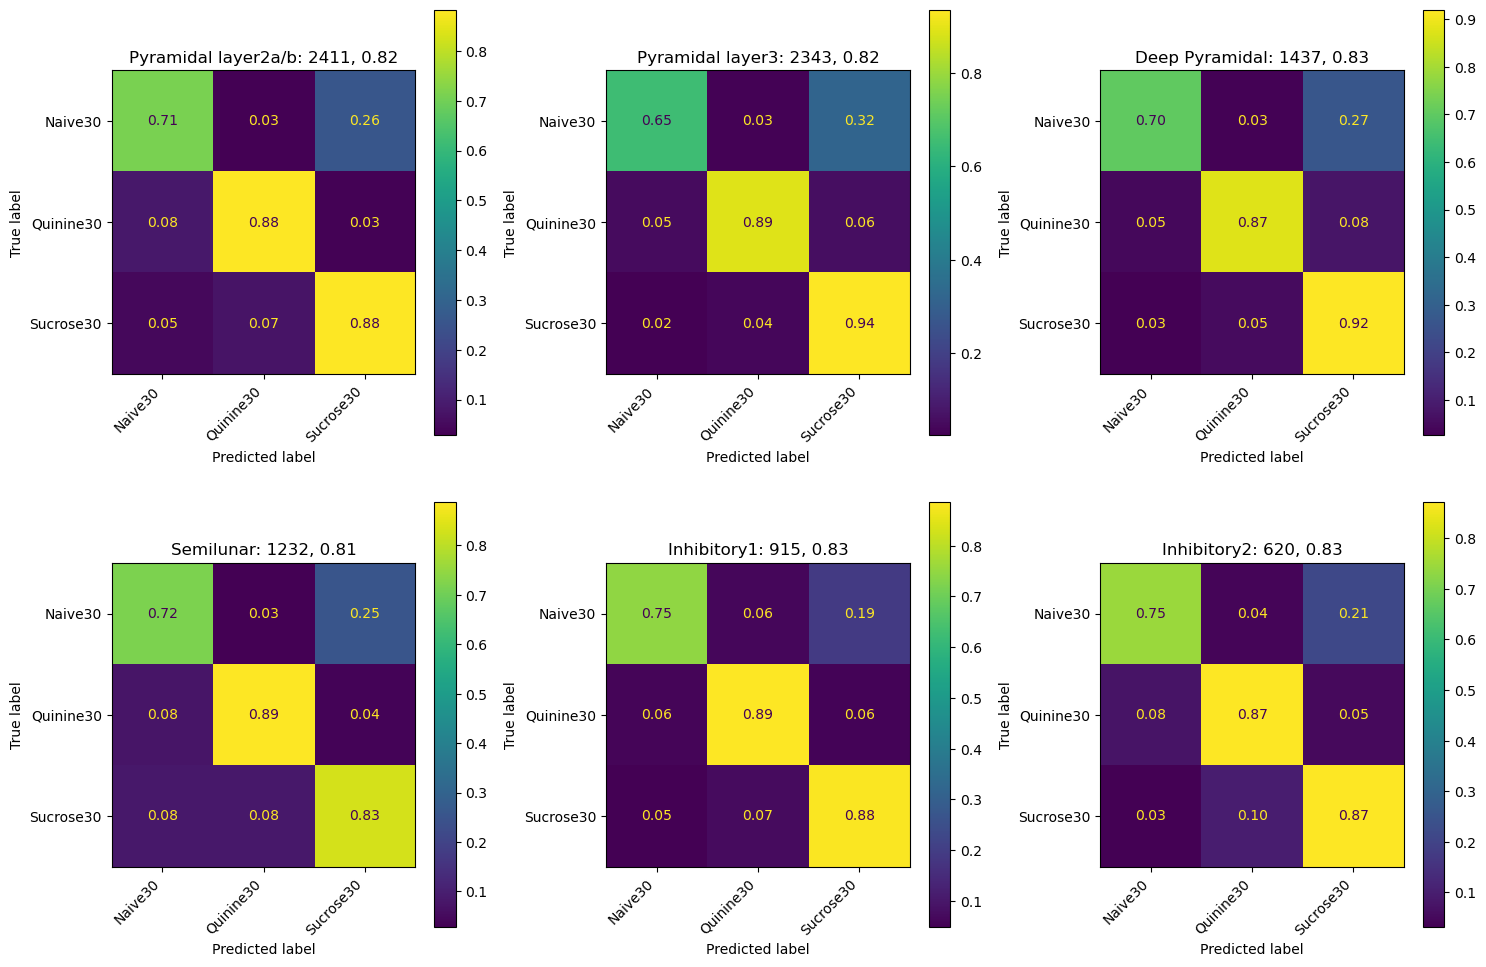

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


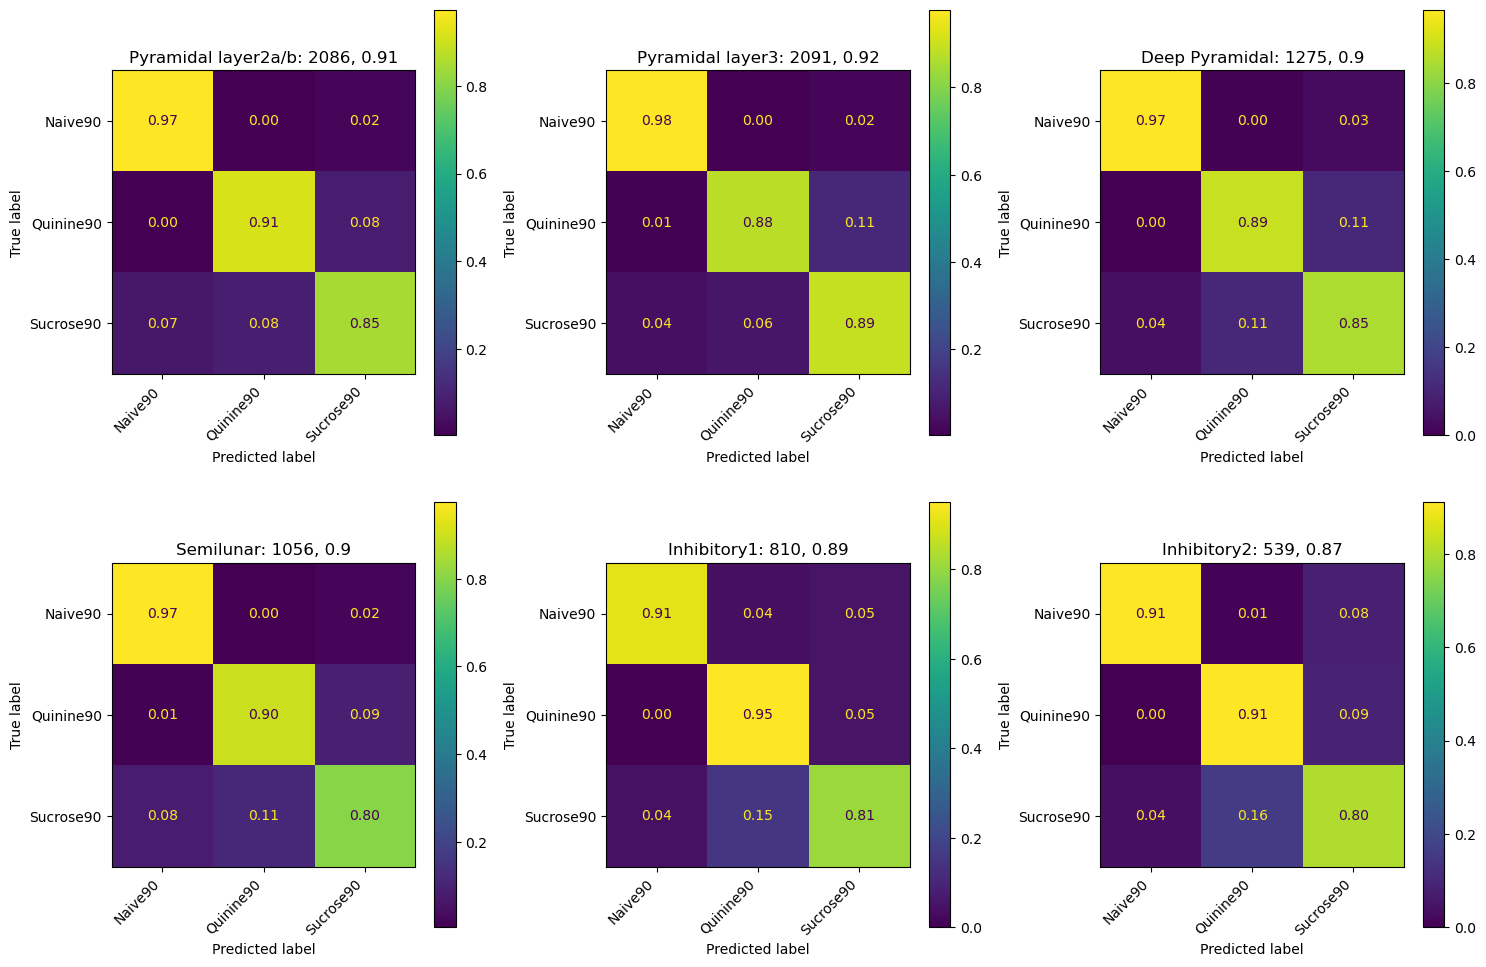

In [48]:
# print(m30_train.obs['leiden'])
# print(m30_test.obs['condition'])
# print(m30_test.obs['encoded_condition'])

# Loop through each condition

data = pd.DataFrame()
# Create a figure with subplots

# 30 min model
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Adjust grid based on the number of clusters
axes = axes.flatten()  # Flatten for easier iteration
for i in range(6):
    cluster_samples = m30_test[m30_test.obs['leiden'] == str(i)]
    X = cluster_samples.raw.X.toarray()
    Y = cluster_samples.obs['encoded_condition']

    # Forward pass
    preds = np.argmax(tf.nn.softmax(model30.predict(X)), axis=1)
    accuracy = np.mean(preds == Y)

    # Compute confusion matrix
    confuse_mat = confusion_matrix(Y, preds, normalize='true')

    # Plot confusion matrix in subplot
    mat = ConfusionMatrixDisplay(confusion_matrix=confuse_mat, display_labels=label30)
    mat.plot(ax=axes[i], values_format=".2f")

    axes[i].set_xticklabels(label30, rotation=45, ha='right')
    axes[i].set_title(f"{cluster_decode[i]}: {len(cluster_samples)}, {round(accuracy, 2)}")

# Adjust layout and save the figure
plt.tight_layout()
plt.show()
    

# 90 min model
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Adjust grid based on the number of clusters
axes = axes.flatten()  # Flatten for easier iteration
for i in range(6):
    cluster_samples = m90_test[m90_test.obs['leiden'] == str(i)]
    X = cluster_samples.raw.X.toarray()
    Y = cluster_samples.obs['encoded_condition']

    # Forward pass
    preds = np.argmax(tf.nn.softmax(model90.predict(X)), axis=1)
    accuracy = np.mean(preds == Y)

    # Compute confusion matrix
    confuse_mat = confusion_matrix(Y, preds, normalize='true')

    # Plot confusion matrix in subplot
    mat = ConfusionMatrixDisplay(confusion_matrix=confuse_mat, display_labels=label90)
    mat.plot(ax=axes[i], values_format=".2f")

    axes[i].set_xticklabels(label90, rotation=45, ha='right')
    axes[i].set_title(f"{cluster_decode[i]}: {len(cluster_samples)}, {round(accuracy, 2)}")
    # 0 = naive, 1 = quinine, 2 = sucrose
    
plt.tight_layout()
plt.show()


### Individual Confusion Matrices for each condition

In [14]:
m30_test.obs['condition'].unique()
# start from m30
for i in X_test.obs['condition'].unique():
    print(f"Leiden cluster: {i}")
    cluster_samples = X_test[X_test.obs['leiden'] == i]
    X = cluster_samples.raw.X.toarray()
    Y = cluster_samples.obs['encoded_condition']
    
    # forward pass
    # X = np.expand_dims(X, axis = 2)
    preds = np.argmax(tf.nn.softmax(model.predict(X)), axis = 1)

    

NameError: name 'X_test' is not defined

# Section 1: 
Single-sample SHAP interpretation

In [6]:
with open('full_test_set_shap.pkl', 'rb') as f:
    full_test_shap = pickle.load( f)

FileNotFoundError: [Errno 2] No such file or directory: 'full_test_set_shap.pkl'

In [ ]:
# printing the shap values and thier shape

copy_shap_vals = np.array(full_test_shap)
copy_shap_vals = np.squeeze(copy_shap_vals)
print(copy_shap_vals.shape)

# aggregating the shap values into a averages.
print(avg_shap_vals.shape)

# producing explanations for the shap values. 
explanation = shap.Explanation(copy_shap_vals)

shap_vals_sample = copy_shap_vals[0, :, :]  # Selecting SHAP values for the first sample
print(shap_vals_sample.shape)

# Single sample interpretation
for class_idx in range(shap_vals_sample.shape[1]):
    explained = shap.Explanation(values=shap_vals_sample[:, class_idx],
                                 feature_names= feature_names)
    shap.plots.bar(explained)
    print(class_idx)


# shap.plots.bar(avg_explanation)



# Section 2
We attempt to aggregate the cells to perform aggregate shap analyses.

In [11]:
# Loading in the data:

def get_shap(time, ct):
    with open(f'../pickles/{time}min-data-{ct}/aggregate_shap.pkl', 'rb') as f:
        shap_vals = pickle.load(f)
    with open(f'../pickles/{time}min-data-{ct}/aggregate_shap_samples.pkl', 'rb') as f:
        shap_samples = pickle.load(f)

    return shap_vals, shap_samples
    

(3, 3000)


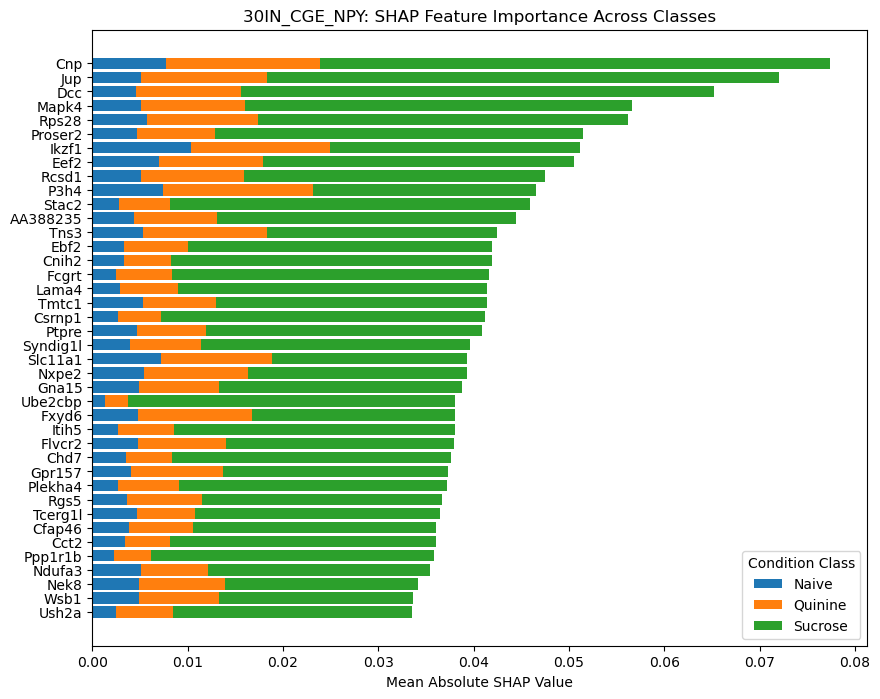

(3, 3000)


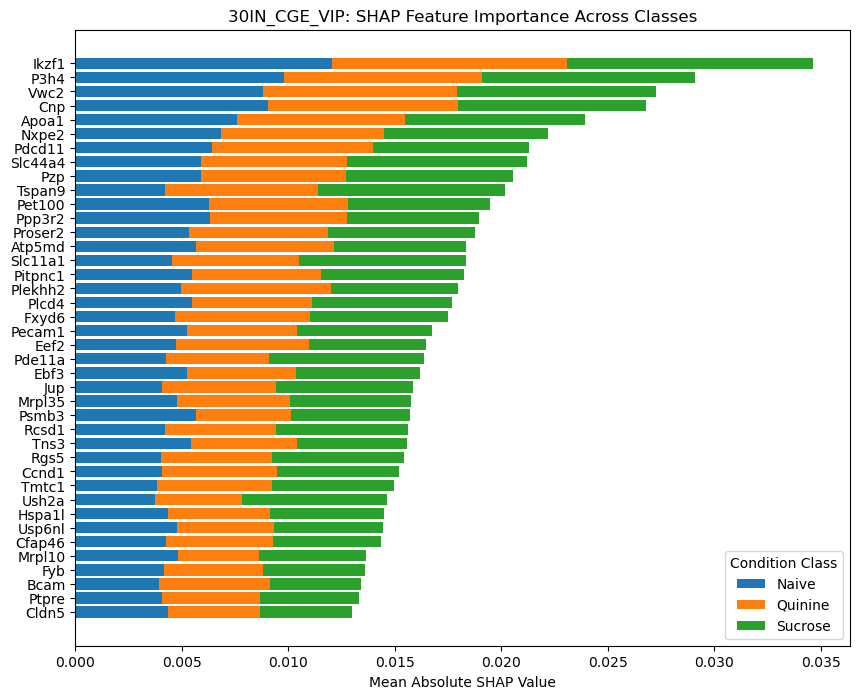

(3, 3000)


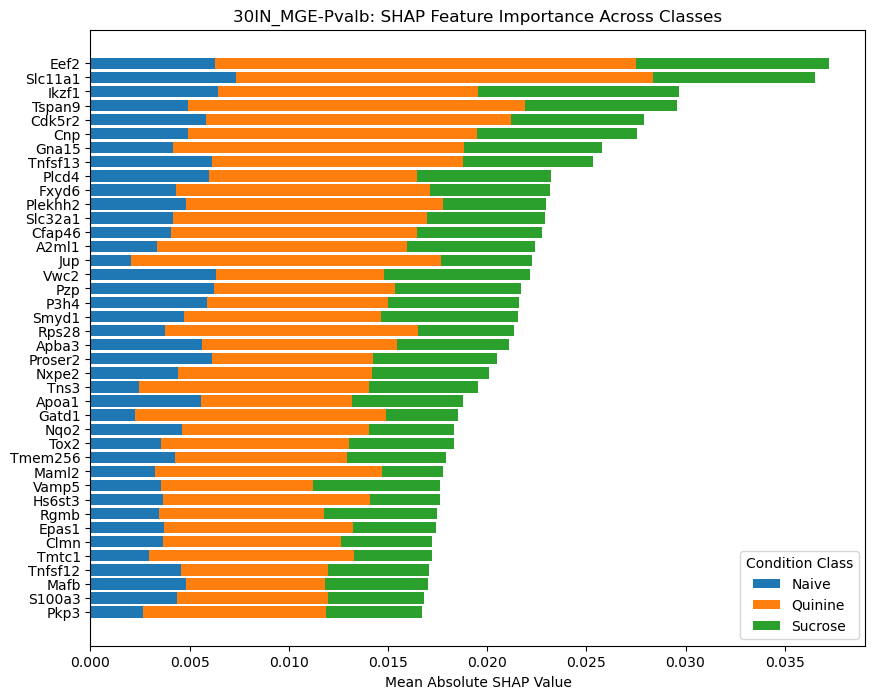

(3, 3000)


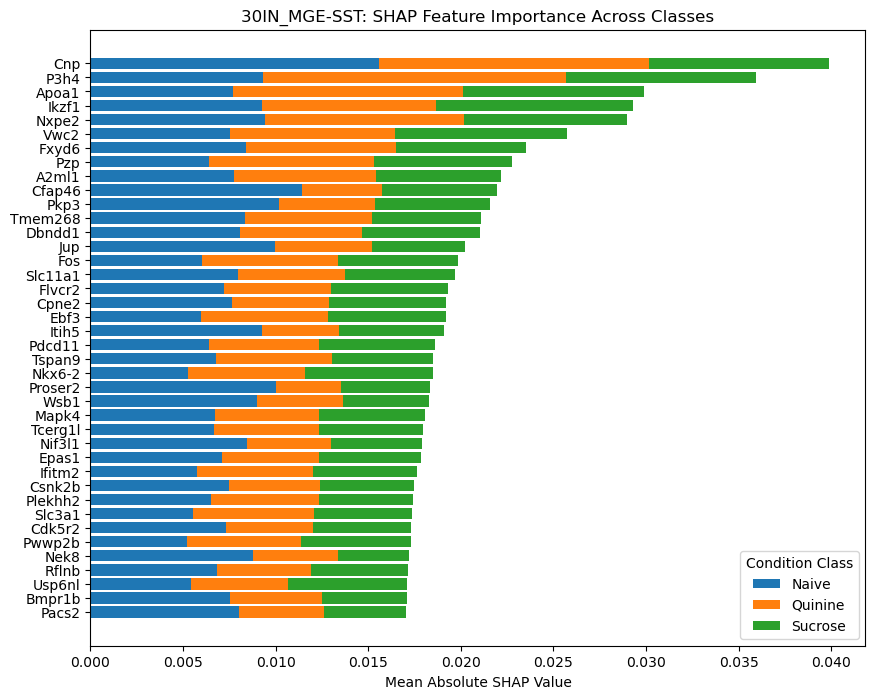

(3, 3000)


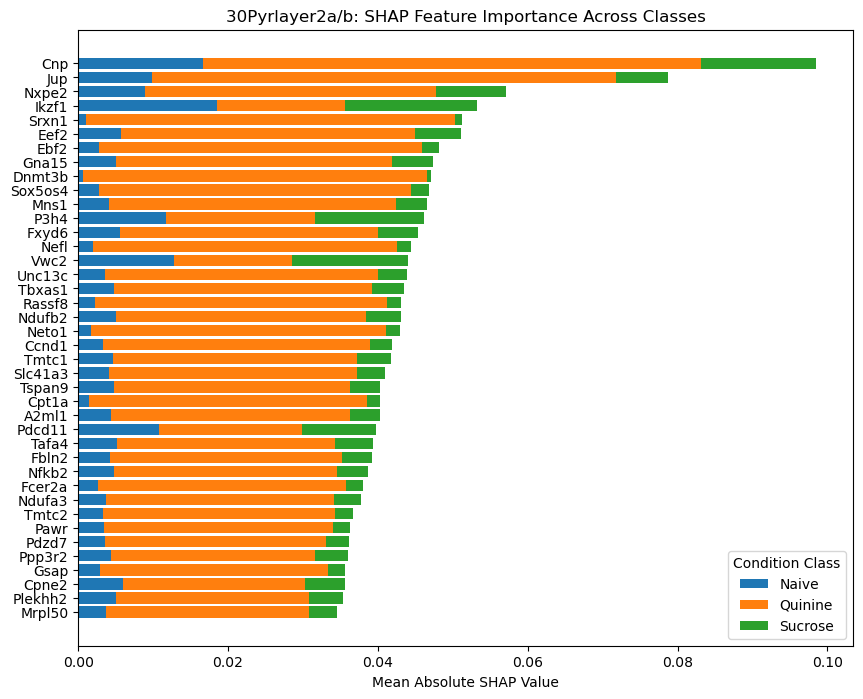

(3, 3000)


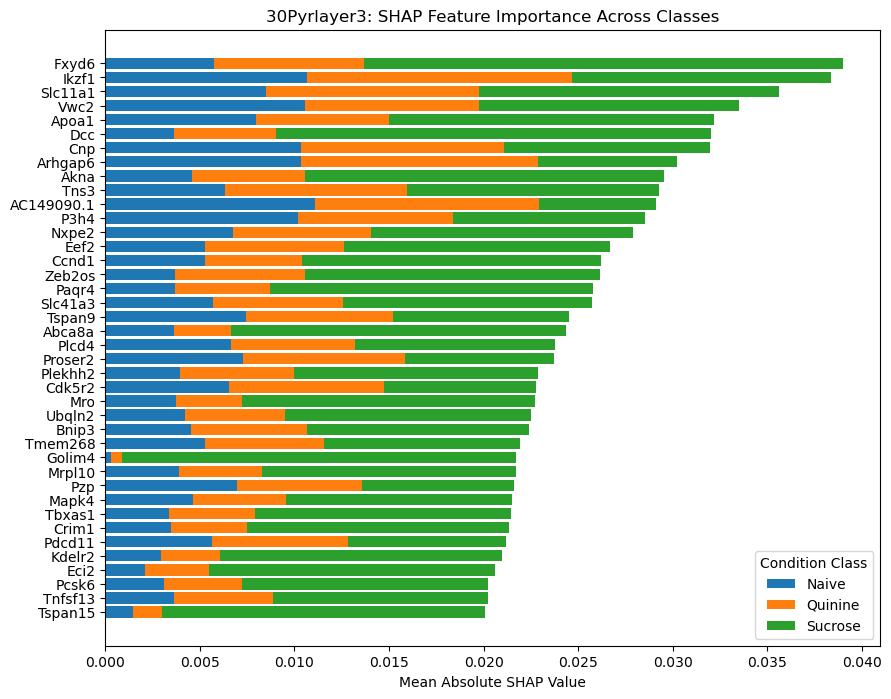

(3, 3000)


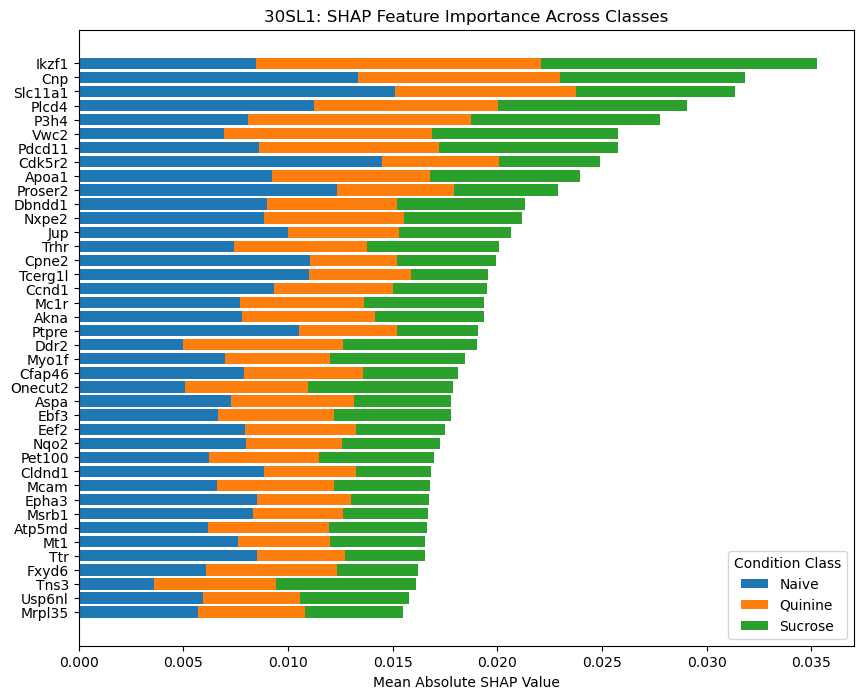

(3, 3000)


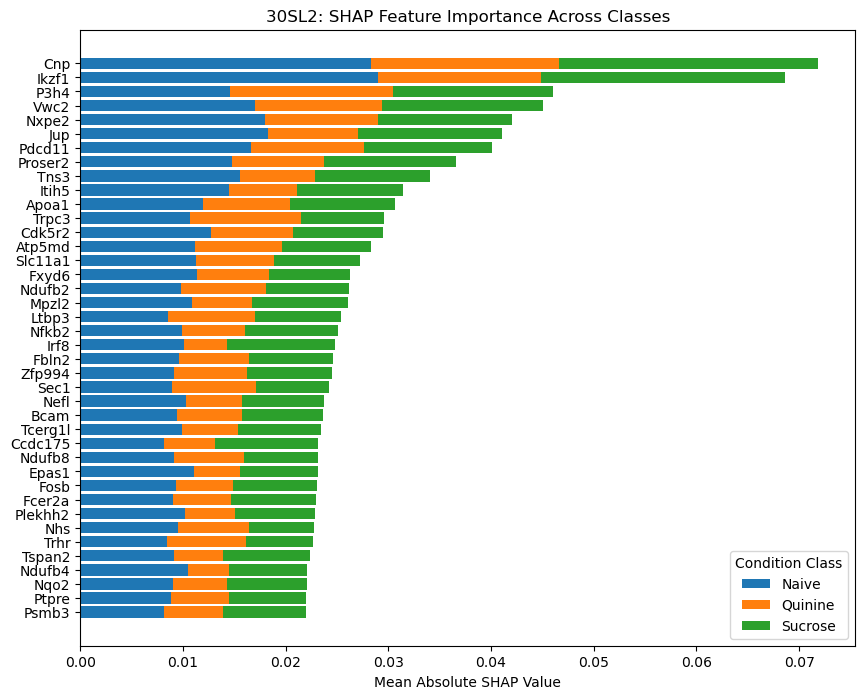

(3, 3000)


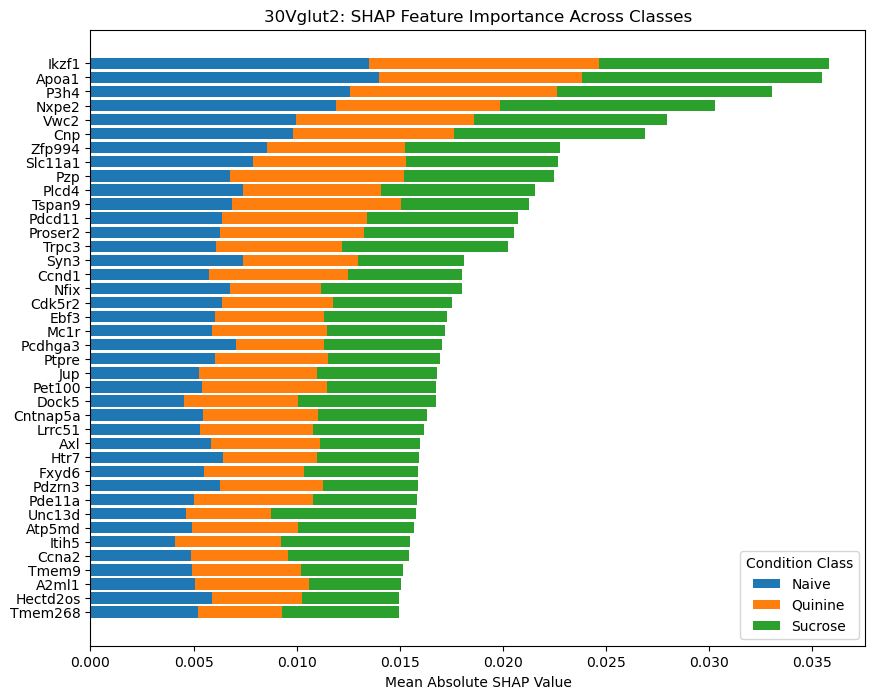

(3, 3000)


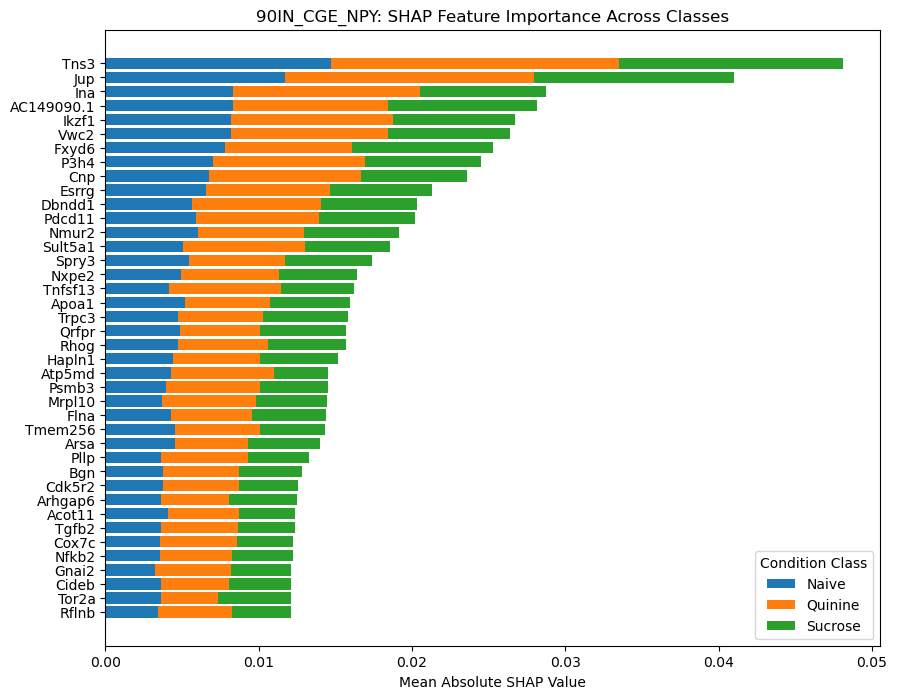

(3, 3000)


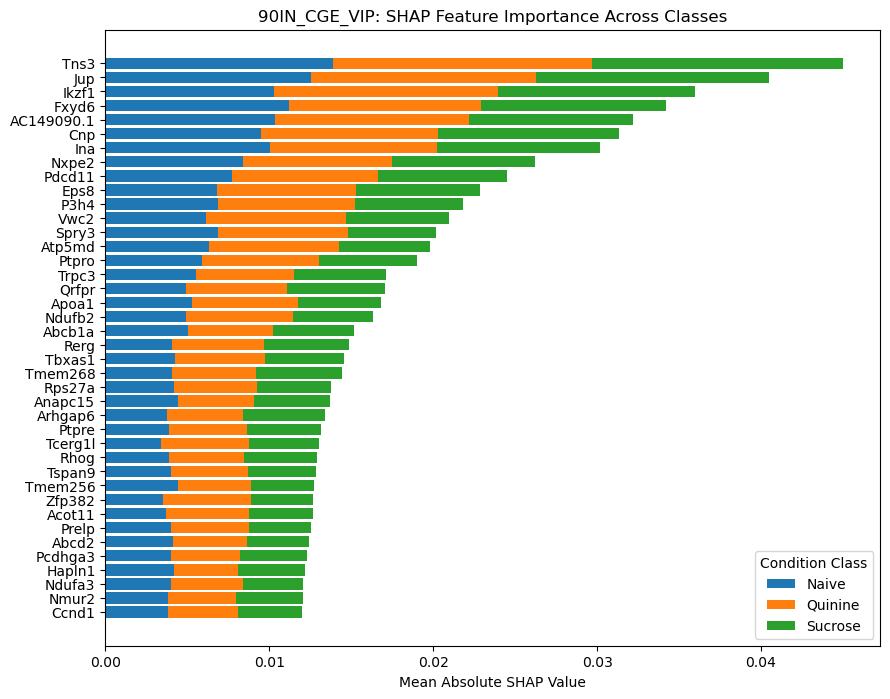

(3, 3000)


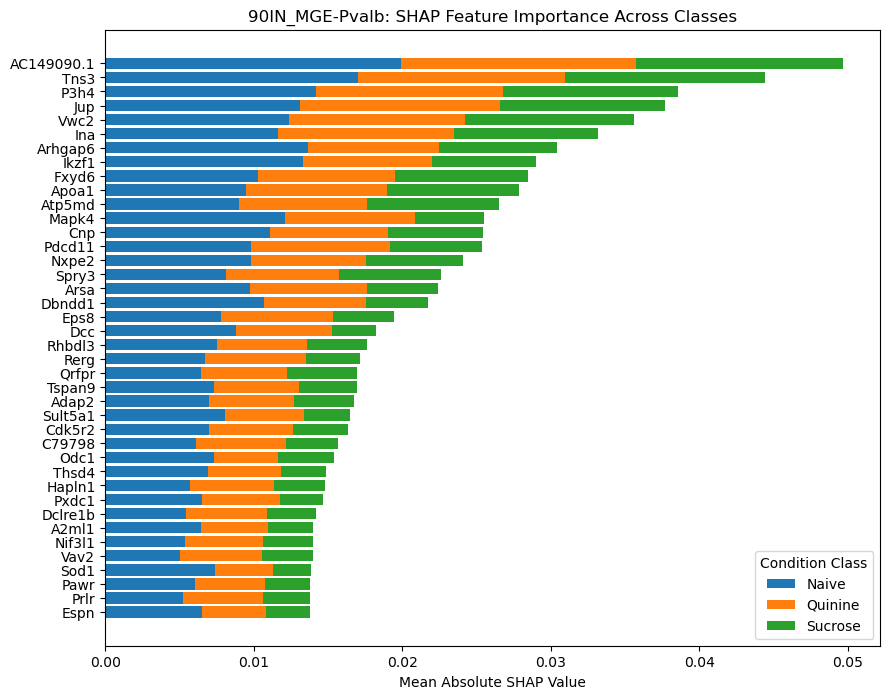

(3, 3000)


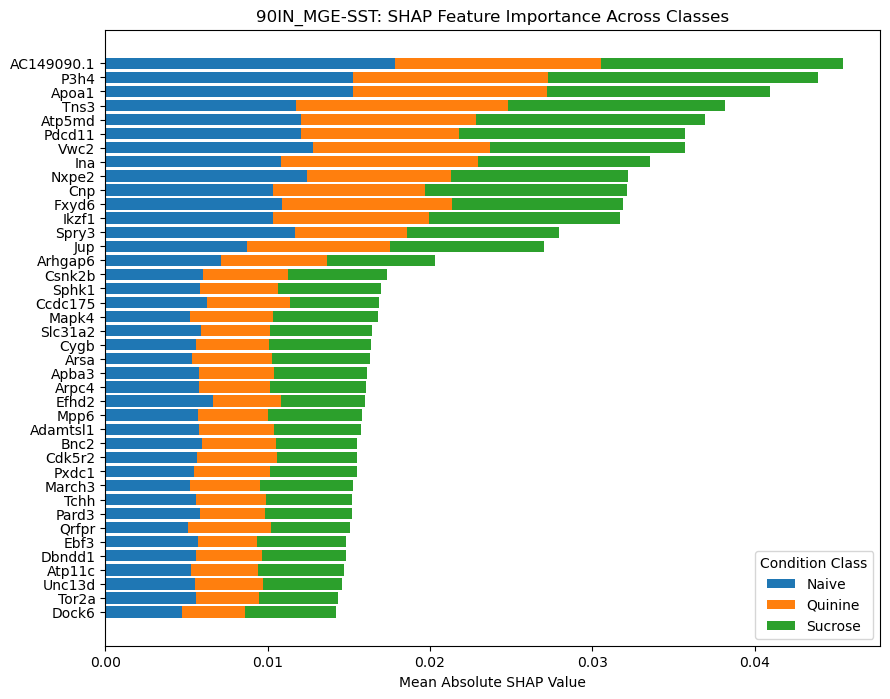

(3, 3000)


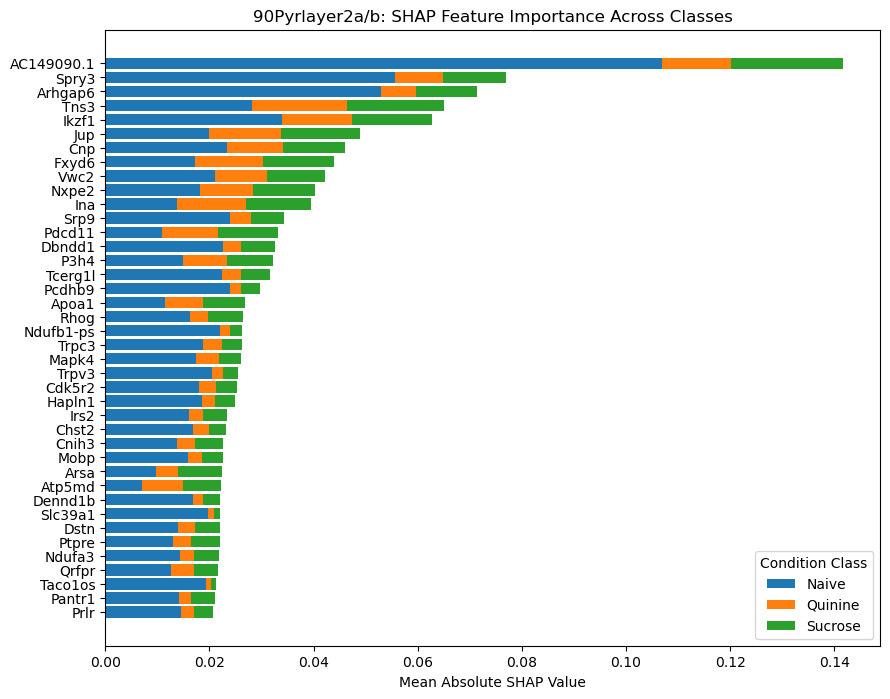

(3, 3000)


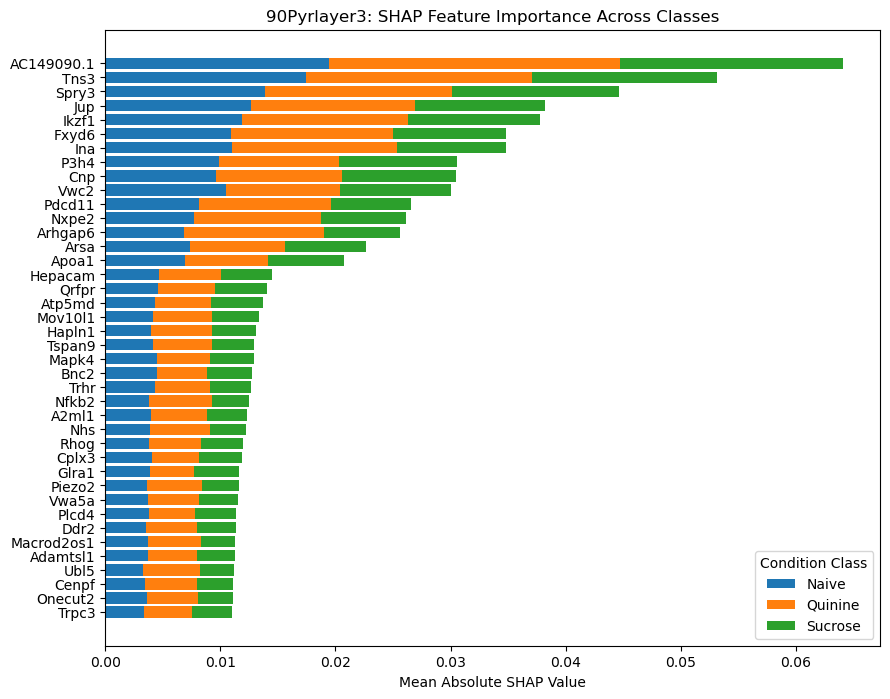

(3, 3000)


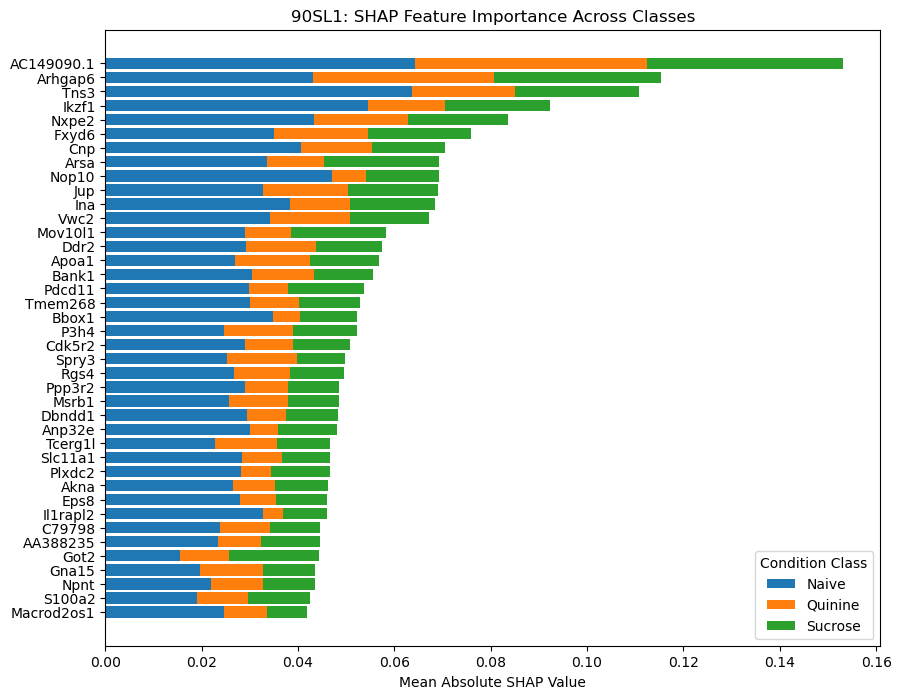

(3, 3000)


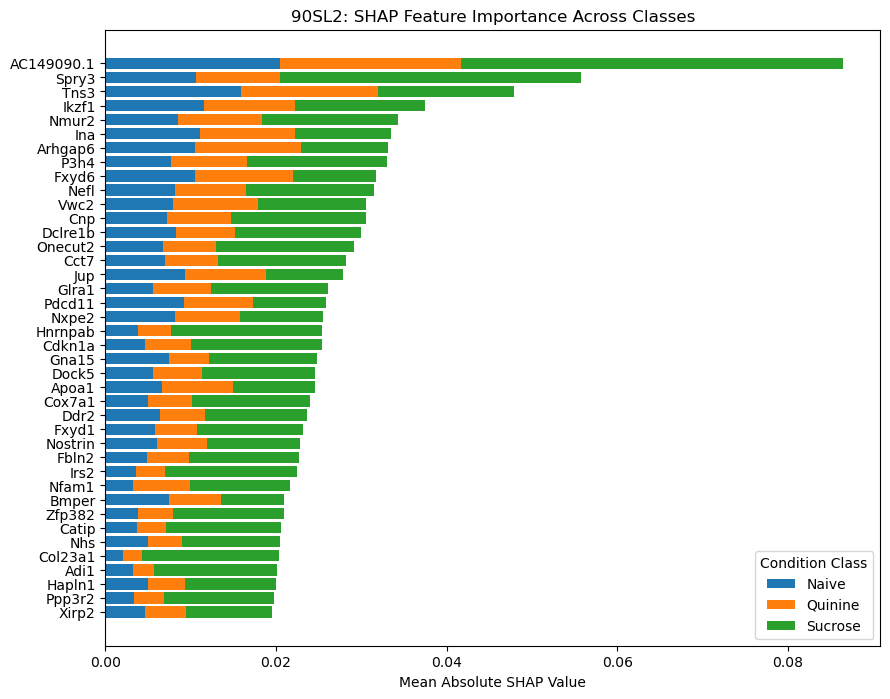

(3, 3000)


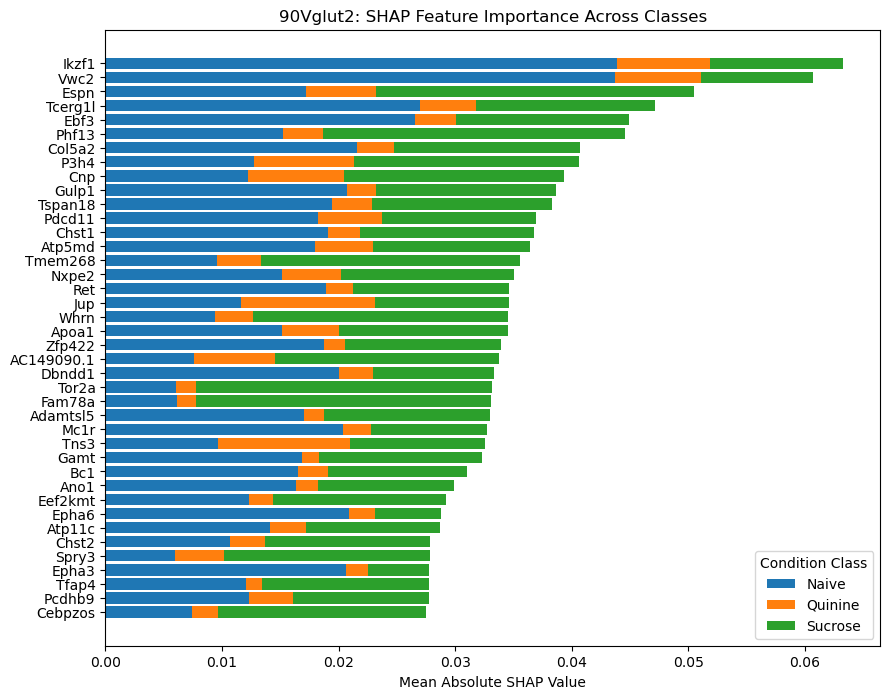

In [12]:
# reshape the shap vals
# shap_df_7 = pd.read_csv(f”{folder}//shap_values.csv”, header=None).to_numpy().reshape((4, 1000, 15992))
# 6:03
# (number of classes, number of reference samples, number of features)
# 6:03
# shap.summary_plot(shap_df_7, features=gene_list, max_display=20, class_names = [5, 30, 50, 70], show=False)

# def generate_shap(model, shap_vals, shap_samples, which_model):
#     feature_names = m30_test.var.index.tolist()
#     print("shap_vals shape:", shap_vals.shape)  # Should be (3, num_samples, num_features)
#     print("Number of feature names:", len(feature_names))  # Should match `hp.num_features`
#     # shap.summary_plot(shap_vals)
#     shap_vals = np.array(shap_vals).reshape((3,  len(shap_samples), hp.num_features,))

#     print("shap_values.shape:", shap_vals.shape)
#     # print("sort_inds.shape:", sort_inds.shape)
#     # print("sort_inds max value:", sort_inds.max())
#     print(shap_vals.mean(1).shape)
#     shap.summary_plot(
#         shap_vals.mean(1),  # Aggregate over samples per class
#         features=feature_names, 
#         max_display=20, 
        
#         plot_type="bar"
#     )    # Set title
#     # plt.title(f"shap for naive{which_model}")
#     # plt.show()

#     shap.summary_plot(shap_vals[1], features = feature_names, max_display = 20)
#     shap.summary_plot(shap_vals[1], features = feature_names, max_display = 20)
    
#     shap.summary_plot(shap_vals[2], features = feature_names, max_display = 20)


def generate_shap(model, shap_vals, shap_samples, which_model):
    feature_names = shap_vals.var.index.tolist()
    # shap.summary_plot(
    #     shap_vals.mean(1),  # Aggregate over samples per class
    #     features=feature_names, 
    #     max_display=20, 
        
    #     plot_type="bar"
    # )    # Set title
    # Reshape SHAP values if necessary
    shap_vals = np.array(shap_vals).reshape((3, len(shap_samples), hp.num_features))

    # Create a figure with 1 row and 3 columns (for each class)

    # Plot SHAP values for each class in a separate subplot by redirecting the output to a specific subplot
    shap.summary_plot(shap_vals[0], features=feature_names, max_display=20, plot_type="bar",)

    shap.summary_plot(shap_vals[1], features=feature_names, max_display=20, plot_type="bar", )


    shap.summary_plot(shap_vals[2], features=feature_names, max_display=20, plot_type="bar", )

    # Adjust layout and display the plots

def generate_shap_stacked_bar(model, shap_vals, shap_samples, which_model):

    feature_names = shap_samples.var.index.tolist()

    # Reshape SHAP values properly
    shap_vals = np.array(shap_vals).reshape((3, len(shap_samples), 3000))
    
    # Compute mean absolute SHAP values per class
    mean_shap_vals = np.abs(shap_vals).mean(axis=1)  # Shape: (3, num_features)
    print(mean_shap_vals.shape)

    # Sum across classes to determine total importance
    total_shap = mean_shap_vals.sum(axis=0)

    # Sort features by total importance
    sorted_indices = np.argsort(total_shap)[::-1][:40]  # Top 20 features
    sorted_features = [feature_names[i] for i in sorted_indices]
    sorted_shap_vals = mean_shap_vals[:, sorted_indices]  # Keep top features

    # Define class colors
    class_labels = ["Naive",  "Quinine", "Sucrose",]
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]  # Blue, Orange, Green

    # Plot stacked bar chart
    fig, ax = plt.subplots(figsize=(10, 8))
    bottom = np.zeros(len(sorted_features))  # Initialize bottom stack

    for i, (class_name, color) in enumerate(zip(class_labels, colors)):
        ax.barh(sorted_features, sorted_shap_vals[i], left=bottom, label=class_name, color=color)
        bottom += sorted_shap_vals[i]  # Stack bars

    ax.set_xlabel("Mean Absolute SHAP Value")
    ax.set_title(f"{which_model}: SHAP Feature Importance Across Classes")
    ax.legend(title="Condition Class")
    plt.gca().invert_yaxis()  # Highest feature at the top
    plt.show()

    return which_model, sorted_features


top_features = pd.DataFrame()
for time in ["30", "90"]:
    for i in mods:
        shap_vals, shap_samples = get_shap(time, i)
        mod, feats = generate_shap_stacked_bar(models[time+i], shap_vals, shap_samples, time+i)

        top_features[mod] = feats

top_features.to_csv("../csvs/top_features.csv")

Sample          30IN_CGE_NPY  30IN_CGE_VIP  30IN_MGE-Pvalb  30IN_MGE-SST  \
Model                                                                      
30IN_CGE_NPY        0.700893      0.767857        0.482143      0.566964   
30IN_CGE_VIP        0.647887      0.661972        0.471831      0.573944   
30IN_MGE-Pvalb      0.540541      0.648649        0.671171      0.639640   
30IN_MGE-SST        0.558065      0.661290        0.487097      0.593548   
30Pyrlayer2a/b      0.395322      0.356725        0.345029      0.443275   
30Pyrlayer3         0.455737      0.373617        0.348282      0.464473   
30SL1               0.379645      0.408724        0.347334      0.453958   
30SL2               0.389868      0.389868        0.352423      0.438326   
30Vglut2            0.516432      0.483568        0.427230      0.586854   

Sample          30Pyrlayer2a/b  30Pyrlayer3     30SL1     30SL2  30Vglut2  
Model                                                                      
30IN_CGE_NP

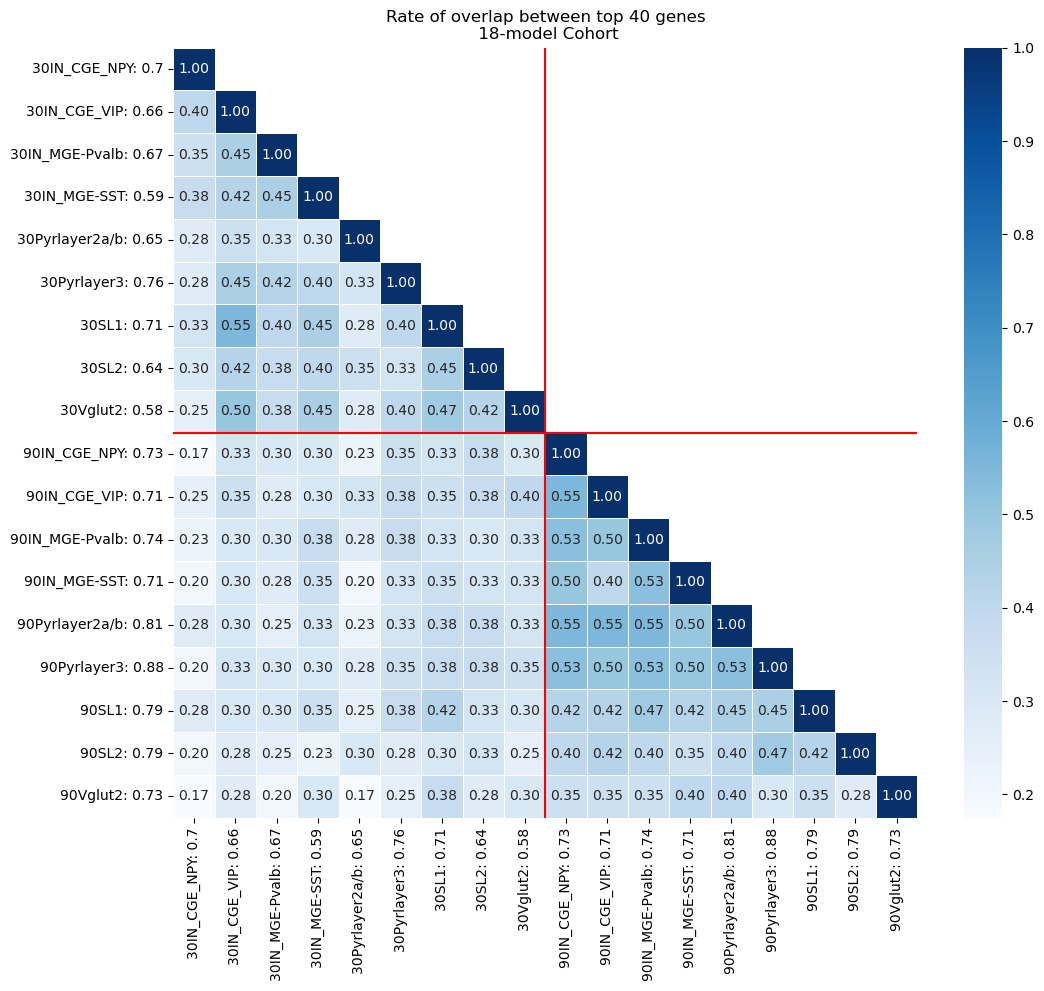

In [15]:
print(cross_predict30)
top_features
overlap = pd.DataFrame(index = top_features.columns.tolist())
for col in top_features.columns:
    curr = []
    for other in top_features.columns:
        curr.append(len(set(top_features[col]).intersection(set(top_features[other])))/40)
    overlap[col] = curr

overlap.columns = [f'{x}: {cross_predict30.loc[x, x].round(2)}' for x in time_mods if x in cross_predict30] + [f'{x}: {cross_predict90.loc[x, x].round(2)}' for x in time_mods if x in cross_predict90]
overlap.index = [f'{x}: {cross_predict30.loc[x, x].round(2)}' for x in time_mods if x in cross_predict30] + [f'{x}: {cross_predict90.loc[x, x].round(2)}' for x in time_mods if x in cross_predict90]

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(overlap, dtype=bool), k=1)

# Plot the heatmap with the mask
plt.figure(figsize=(12, 10))
sns.heatmap(overlap, annot=True, cmap='Blues', fmt=".2f", linewidths=0.5, mask=mask)

plt.title("Rate of overlap between top 40 genes\n 18-model Cohort")
n = len(overlap.columns)
# Determine the middle of the matrix to separate into quadrants
mid_point = n // 2

# Draw horizontal and vertical lines to separate quadrants
plt.hlines(y=mid_point, xmin=0, xmax=n, colors='red', linewidth=1.5)
plt.vlines(x=mid_point, ymin=0, ymax=n, colors='red', linewidth=1.5)

plt.show()


In [45]:

# 850 x 3000 x 3
# sample 1 predictaed = 0
# 850 x 3000
# in flattening this 850 x 3000 shape, what is the method we should use? 


# # Extract the mean absolute SHAP values for each feature
# mean_abs_shap_vals = np.mean(np.abs(explanation.values), axis=0)

# # Get the indices of the top 110 features
# top_100_indices = np.argsort(mean_abs_shap_vals)[-101:][::-1]

# # Extract the feature names for the top 110 features
# top_100_features = [explanation.feature_names[i] for i in top_100_indices]

# print(top_100_features)

# looking at the overlap with the canon iegs and lrgs
lrgs = [
    "Fndc9", "Meox1","Scg2", "Kcnj4","Glt28d2", "Gpr3","Mbnl2", "Trip10","Maml3", "Cd109","Csrnp1", "Gpr63","Sv2c", "Tll1","Hsd17b12", "Bmp3","Crhbp", "Stc1","Col10a1", "Klhl4","Gch1", "Sostdc1","Tac1", "Spred3","Errfi1", "Sowahb","C2cd4b", "Slitrk4","Prok2", "Mfap3l","Slc2a3", "Kcna1","Cartpt", "Fezf2","Kcnj3", "Dennd2c","Chrm2", "Stc2","Mlf1", "Hdac9", "Dusp4", "Hunk","Popdc3", "Pthlh","Ccdc184", "Pnoc","Dusp14", "Kcnh8","Kcnf1", "Acan","Alpk1", "Gper1","Rgs2", "Omg","Wdr90", "Chac1","Grasp", "Stac","Coq10b", "Nptx2","Fam126b", "Kcna4","Mctp2", "Sema3e","Bdnf", "Palmd", "Gem", "Rab39","Tiparp", "Serpinb2","Gpr22", "Hspb3","Pcsk1", "5430416O09Rik","Cystm1", "9430020K01Rik","Ptgs2", "Dmxl1", "Per1", "Cdkn1a", "Ptger4", "Fbxo33", "Adm", "Sik1","Pax1", "Crem","Pou3f1", "Spty2d1","Chst8", "Tbc1d8b","Pgap1", "Zdbf2","Lipg", "Bves", "Adcyap1", "Chml","Slc7a1", "Klf14", "Pcdh8", "Rgs4", "Areg", "Rnf128","Nap1l5", "Peg10","Tnn", "Nr4a3","Stk40", "Atp10d","Rel", "Slc6a17","Slc40a1", "Mthfd2","Brinp1", "Nrn1","Per2", "Msantd1","Rem2", "Gprc5a","Eprs", "Pam","Sertad1", "Tacr3","Hcrtr2", "Herpud1","Stard4", "Nppc","Pard6a", "Plagl1","Pcdh20", "Osgin2","Mpp7", "Kcns2","Cort", "Sstr2","Ell2", "Gpr26","Sult2b1", "Rheb","Acsl4", "Nr4a2","Nefl", "Fosl2","Tec", "Fam46a","Gmeb2", "Rasgrp1", "Gltscr2", "Atf3", "Kitl", "Baz1a", "Npbwr1", "4931440P22Rik", "Cfap43", "D16Ertd472e"
]
iegs = [
    "Fos", "Fosb", "Fosl1", "Fosl2", "Jun", "Junb", "Jund", "Egr1", "Egr2", "Egr3", "Egr4",
    "Nr4a1", "Nr4a2", "Nr4a3", "Arc", "Homer1", "Rheb", "Rgs2", "Plk2", "Ptgs2", "Bdnf", "Inhba",
    "Nptx2", "Plat", "Nrn1", "Myc", "Dusp1", "Dusp5", "Dusp6", "Pcdh8", "Cyr61", "Gadd45b",
    "Trib1", "Gem", "Btg2", "Ier2", "Npas4", "Rasd1", "Crem", "Mbnl2", "Arf4", "Gadd45g", "Arih1",
    "Nup98", "Ppp1r15a", "Fbxo33", "Per1", "Per2", "Maff", "Zfp36", "Srf", "Mcl1", "Ctgf", "Il6",
    "Atf3", "Rcan1", "Ncoa7", "Cxcl2", "Bhlhe40", "Slc2a3", "Nfkbia", "Ier3", "Sgk1", "Klf6",
    "Klf10", "Nfkbiz", "Flg", "Gbp2b", "Tnfaip3", "Cebpd", "Hbegf", "Ldlr", "Tsc22d1", "F3",
    "Ccl2", "Csrnp1", "Pmaip1", "Zfp36l2", "Plau", "Ccl5", "Saa3", "Ifnb1", "Tnf", "Irf1",
    "Cd83", "Map3k8", "Socs3", "Csf2", "Il1a", "Cxcl1", "Il12b", "Il1b", "Sod2", "Pim1",
    "Peli1", "Tlr2", "Ccl3", "Noct", "Bcl3", "Ifit2", "Icam1", "Ifit1", "Tnfsf9", "Ccrl2",
    "Cxcl10", "Gbp2", "Il10", "Clec4e", "Acod1", "Mmp13", "Cxcl11", "Il23a", "Arhgef3",
    "Serpine1", "Traf1", "Vcam1", "Ackr4", "Marcksl1", "Nfkbid", "Ikbke", "Ccl12", "Ifit3",
    "Cebpb", "Zfp36l1", "Txnip", "Nfib", "Hes1", "Pias1", "Klf2", "Cd69", "Dusp2", "Wee1",
    "Thbs1", "Sik1", "Gdf15", "Ier5", "Rgs1", "Id2", "Apold1", "Egr4", "Fosb", "Npas4",
    "Fos", "Btg2", "Ier2", "Amigo3", "Egr3", "Dusp1", "Klf4", "Arc", "Gadd45g", "Ppp1r15a",
    "Egr2", "Dusp5", "Maff", "Junb", "Nr4a1", "Egr1"
]

def extract_shap(explanation):
    # # Extract the mean absolute SHAP values for each feature
    print(explanation.values)
    mean_abs_shap_vals = np.mean(np.abs(explanation.values), axis=0)
    print(mean_abs_shap_vals)
    
    # Get the indices of the top 110 features
    top_100_indices = np.argsort(mean_abs_shap_vals)[:][::-1]
    
    # Extract the feature names for the top 110 features
    features = [explanation.feature_names[i] for i in top_100_indices]
    for i, f in enumerate(features):
        if f in lrgs:
            print(f'lrg: {f},{i}')
        if f in iegs:
            print(f'ieg: {f},{i}')

    
print(explanation30.shape)
extract_shap(explanation30)


(896, 3000)
[[ 5.92877250e-03 -7.70880317e-04  4.98951646e-04 ...  2.14009383e-03
   2.12143874e-04  2.56130025e-02]
 [ 2.90187378e-03 -4.10361652e-04 -6.81975565e-04 ...  7.87490630e-04
   1.35692346e-04 -2.75944844e-02]
 [ 3.60952900e-03 -5.31865226e-04  7.90348058e-05 ...  2.19511450e-03
   1.76619549e-04 -3.38256955e-02]
 ...
 [ 1.77265238e-03  2.77453661e-03  3.53976004e-02 ...  2.80015776e-03
  -2.42647380e-04  4.17957604e-01]
 [ 1.43996545e-03 -6.18916762e-04 -9.88796237e-04 ...  1.47016081e-05
   2.48169272e-05  1.43849710e-02]
 [ 2.83131562e-03  2.81180779e-04 -1.39921351e-04 ...  2.19324735e-04
  -5.53602695e-05 -1.17199402e-03]]
[0.00589678 0.00121971 0.0070063  ... 0.00276743 0.00015373 0.05466936]
lrg: Pgap1,129
ieg: Nfib,167
lrg: Chrm2,250
lrg: Rgs4,257
lrg: Maml3,269
lrg: Omg,288
lrg: Bdnf,306
ieg: Bdnf,306
lrg: Chst8,401
lrg: Nap1l5,404
lrg: Nptx2,410
ieg: Nptx2,410
lrg: Slitrk4,444
ieg: Junb,453
ieg: Jund,459
lrg: Kcnf1,472
lrg: Nrn1,476
ieg: Nrn1,476
ieg: Egr1,483
ieg

In [13]:
# printing to a csv

import pandas as pd
# Extract the feature names and their corresponding mean absolute SHAP values for the top 110 features
top_100_features = [explanation.feature_names[i] for i in top_100_indices]
top_100_values = [mean_abs_shap_vals[i] for i in top_100_indices]

# Create a DataFrame
top100_df =  pd.DataFrame({
    'Aggregate SHAP': top_100_features
})

# # Save to CSV
# top_110_df.to_csv('top_110_features_new.csv', index=False)

# Section 3: SHAP by cluster


In [50]:
X_test.obs['leiden']



GGGCCATCACTTGTCC-1-2-adlib30      3
ACGGGTCCACCTGTCT-1-1-bored        6
CTGCAGGAGACATCCT-1-1-quinine30    2
GGCAGTCGTATTTCTC-1-1-naive90      1
ATTACTCAGTCTCTGA-1-1-adlib90      8
                                 ..
TTGCATTCAATCCAGT-1-0-naive90      0
GATGTTGCACACTTAG-1-0-bored        4
CTGTACCCAGGTGTTT-1-0-naive30      0
TGCTTCGGTCGTACAT-1-1-sucrose90    1
GTAGGAGTCTCCAAGA-1-0-sucrose30    1
Name: leiden, Length: 18990, dtype: category
Categories (9, object): ['0', '1', '2', '3', ..., '5', '6', '7', '8']

0
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
[1 1 0 0 0 0 1 0 2 2 1 1 1 1 1 2 0 1 2 2 2 2 0 1 2 1 2 2 0 2 2 1 0 2 0 2 2
 0 2 0 2 0 1 1 1 1 0 1 0 2 2 0 0 2 0 1 2 0 2 1 0 0 1 2 2 0 2 2 1 2 1 2 2 1
 2 2 2 1 1 0 2 1 2 2 2 0 2 2 1 1 1 0 0 2 2 1 0 1 2 2 2 2 0 2 1 1 2 2 1 0 2
 2 2 1 1 0 0 2 0 2 0 1 1 2 0 0 0 2 2 0 2 2 1 1 1 2 1 2 2 2 2 2 2 2 0 2 2 2
 0 2 1 2 0 2 2 1 2 2 1 2 1 1 1 2 2 0 1 2 0 1 0 2 2 2 0 2 1 2 2 2 0 2 1 2 2
 2 1 1 2 2 1 2 1 2 2 2 2 2 2 2 2 2 2 1 2 2 2 0 2 0 0 2 2 2 0 1 2 1 2 2 2 1
 1 0 0 2 0 1 2 1 0 2 1 2 2 0 2 0 1 2 2 2 1 2 1 1 1 0 1 2]


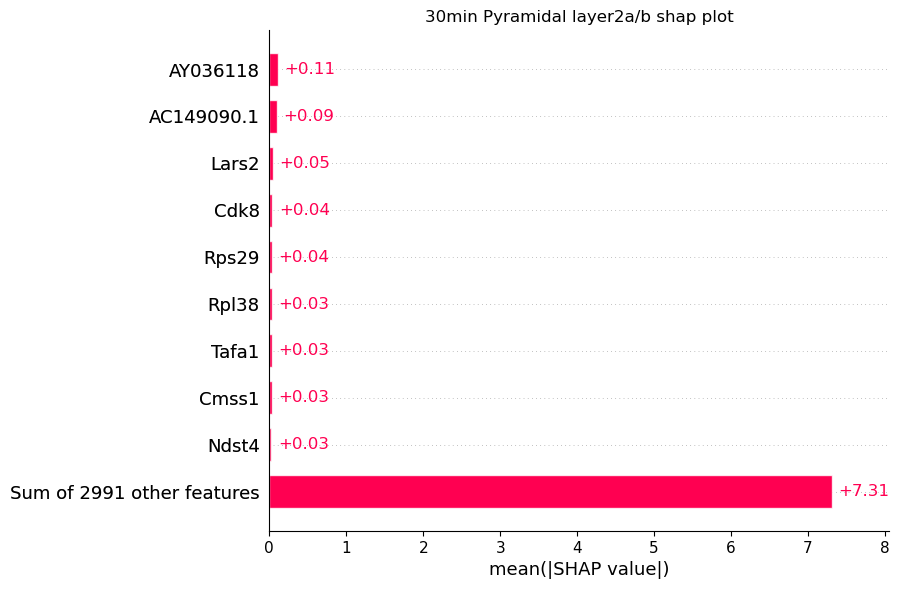

1
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
[2 2 0 2 0 2 0 2 1 1 0 1 2 2 2 2 0 0 0 2 2 0 1 2 2 2 1 1 2 1 2 2 0 1 0 2 1
 2 2 1 2 1 2 0 1 2 2 0 2 1 1 2 0 1 2 2 0 0 2 2 2 2 0 0 2 0 1 1 1 1 2 2 1 1
 1 0 0 1 2 2 0 0 1 0 2 1 1 2 2 2 0 1 2 0 1 1 1 0 2 1 2 0 2 2 2 2 2 0 1 2 0
 2 0 2 2 1 1 2 0 2 2 1 2 2 2 1 0 2 0 2 2 2 1 2 0 2 2 1 1 2 2 2 2 0 2 2 0 1
 2 1 2 0 2 1 2 1 0 1 2 1 2 2 0 2 0 2 2 1 0 2 2 1 0 2 2 1 0 2 2 2 1 1 1 0 2
 2 2 1 1 0 1 1 2 1 1 2 1 2 1 2 1 1 2 1 0 0 2 1 2 2 2 2 0 0 0 2 2 0 0 1 1 0
 0 2 2 2 0 0 0 2 2 0 2 2 1 2 1 2 2 2 2 2 2 0 2 0 1 2 1 2]


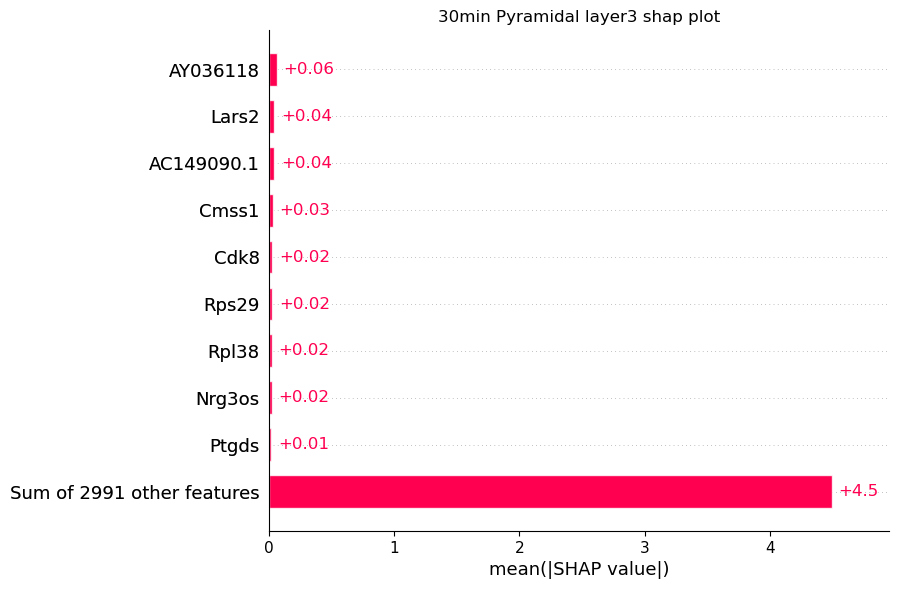

2
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
[1 2 1 1 0 1 2 2 0 2 2 0 1 1 2 0 2 1 1 2 2 2 0 0 0 2 2 0 1 2 1 2 1 0 2 0 1
 0 0 0 1 2 1 1 1 0 2 2 2 2 2 1 1 1 1 1 0 1 1 2 1 2 2 2 2 2 2 1 2 1 1 0 2 1
 1 2 2 2 2 2 1 0 1 0 2 1 1 1 2 0 1 2 2 2 1 2 0 0 0 2 2 0 1 0 1 1 2 0 1 1 0
 2 0 1 0 2 0 2 2 0 2 2 2 2 2 1 1 2 0 2 1 2 0 0 0 0 1 2 2 1 0 1 2 0 1 1 0 0
 0 1 2 1 2 0 2 2 1 2 0 2 2 0 0 2 2 1 1 2 1 0 0 0 2 2 0 2 1 0 1 2 1 2 1 1 1
 1 1 1 2 2 2 0 1 1 2 2 0 1 2 1 0 2 1 1 1 0 1 1 0 2 2 1 1 0 2 0 2 0 2 2 2 0
 2 2 2 0 1 2 0 2 1 2 2 1 1 2 2 1 2 2 0 2 2 1 0 2 1 0 2 1]


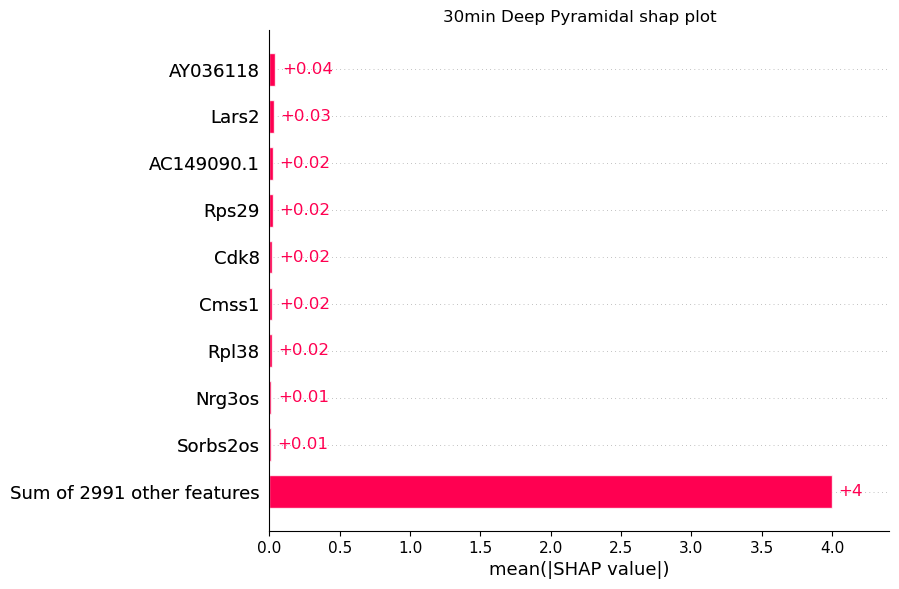

3
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
[2 1 2 2 0 1 2 2 1 2 2 0 2 2 0 1 1 2 1 0 2 1 1 2 1 0 1 0 2 1 1 1 1 1 1 1 2
 2 0 0 0 2 1 2 0 1 1 1 1 1 0 0 0 1 0 2 1 0 1 1 1 2 1 2 2 1 2 0 2 0 0 1 1 0
 1 2 0 1 1 1 0 1 1 1 1 2 2 1 2 1 1 0 1 0 0 2 0 2 2 0 2 2 1 0 0 1 1 1 1 1 0
 2 1 0 1 1 2 1 2 2 0 0 2 0 1 1 0 1 1 0 0 2 2 1 1 1 0 0 2 2 0 0 1 0 0 1 0 1
 1 0 1 1 0 0 1 0 2 2 2 1 2 0 0 1 0 1 0 1 1 2 1 2 2 2 0 1 2 2 1 0 1 0 0 1 2
 0 0 0 2 1 2 0 2 1 0 0 0 2 0 0 0 1 1 2 0 0 2 0 1 1 0 1 2 0 0 2 0 1 0 0 1 1
 2 0 1 1 1 0 1 0 2 1 1 2 1 2 2 2 1 2 2 2 2 1 2 1 2 0 1 2]


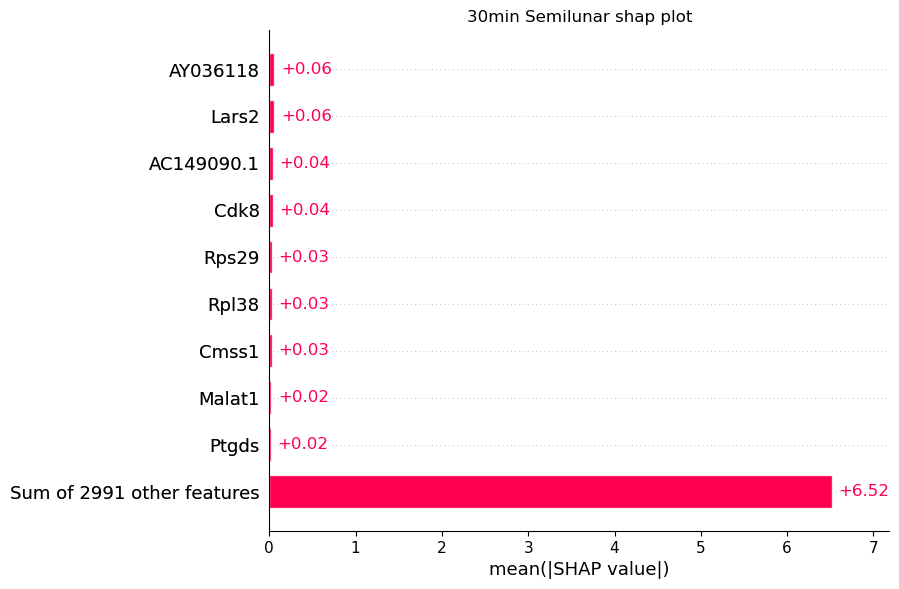

4
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
[2 0 1 0 0 1 1 0 1 2 2 2 0 2 1 2 2 0 1 1 0 0 1 1 1 0 1 2 0 0 2 0 1 2 1 2 2
 2 1 1 1 1 2 0 0 1 1 0 1 0 1 0 1 2 1 2 0 0 0 0 1 1 0 0 1 0 1 0 0 2 0 0 0 2
 0 0 1 1 0 1 0 1 1 1 2 0 2 1 2 1 0 2 0 1 2 1 1 0 1 2 2 0 2 0 1 0 1 2 0 0 0
 2 0 1 1 1 2 2 0 0 0 1 1 1 2 1 2 2 1 2 1 0 2 0 2 2 0 0 2 2 1 1 2 1 2 1 2 1
 1 0 2 1 1 1 0 0 1 1 0 0 2 2 1 1 0 2 1 1 0 1 0 2 1 1 2 1 2 0 0 0 0 2 0 0 2
 2 1 2 0 1 2 2 1 1 1 0 2 1 2 1 2 0 2 2 2 0 1 2 1 0 1 0 1 2 1 0 2 2 0 1 2 0
 1 1 2 2 1 1 0 1 0 2 0 2 2 2 0 1 2 2 0 0 0 2 1 2 1 2 1 2]


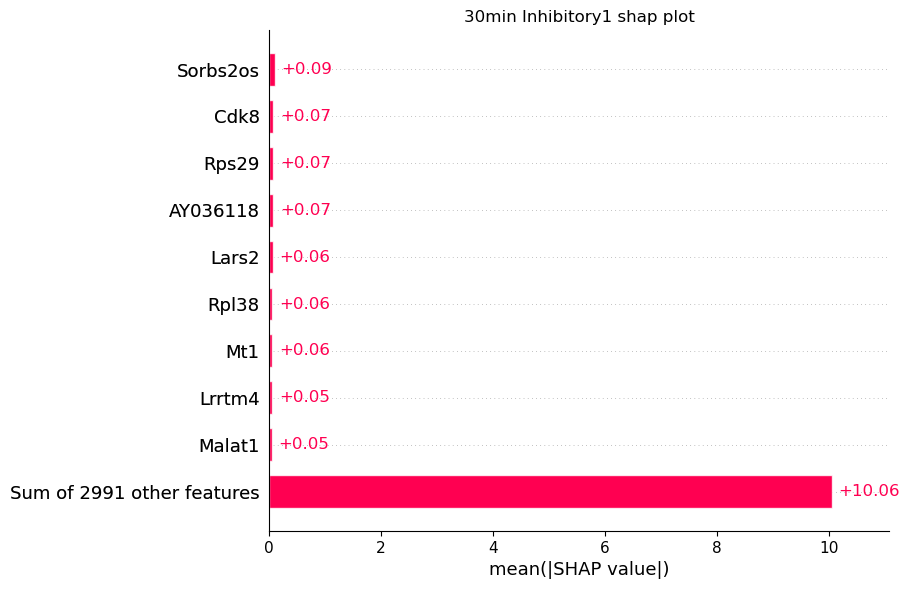

5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
[1 1 0 1 1 0 2 1 1 1 0 2 2 0 2 2 1 1 1 2 1 1 2 0 1 1 2 0 1 2 1 2 0 0 1 0 0
 0 1 1 1 1 2 2 0 2 1 1 1 2 0 0 2 2 0 2 2 0 2 1 2 1 1 1 0 1 0 2 2 1 2 1 0 2
 0 0 2 1 1 1 0 1 2 2 0 2 2 1 2 1 2 0 2 0 1 2 1 0 1 2 0 0 2 1 2 0 2 1 2 1 0
 1 2 0 2 1 2 2 0 1 1 1 2 0 0 0 1 2 2 1 0 2 0 1 1 2 1 1 0 1 0 0 2 0 2 2 0 2
 0 1 0 0 0 1 0 1 0 1 0 0 1 0 1 1 1 2 2 1 2 1 1 1 0 1 2 2 2 0 2 2 1 1 2 2 1
 1 0 2 2 2 2 1 2 2 1 1 1 2 1 1 0 0 1 1 1 1 1 0 2 0 1 0 0 1 2 0 1 0 2 1 2 2
 2 2 2 1 2 2 2 0 0 1 2 2 1 0 2 2 2 0 0 2 0 1 0 1 1 2 2 2]


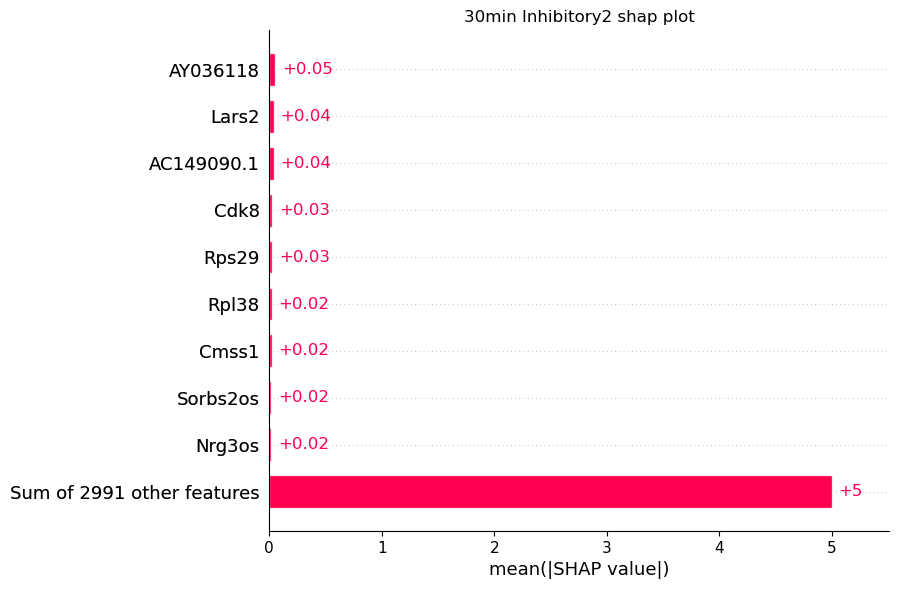

0
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
[2 2 0 1 0 2 1 0 1 1 0 0 0 2 2 2 0 2 0 0 0 1 1 1 2 1 0 1 2 0 0 2 0 1 2 1 2
 2 0 0 2 2 0 0 2 2 2 0 0 2 0 2 2 0 2 0 0 2 2 1 0 0 1 1 1 1 0 1 2 1 0 2 0 2
 0 2 0 1 1 2 1 2 1 0 0 2 0 0 1 2 0 2 1 0 0 0 1 0 1 0 2 0 2 1 2 2 0 0 2 2 1
 2 2 0 0 0 0 2 2 1 2 2 0 0 0 0 0 0 1 0 2 2 0 1 1 2 0 1 0 0 1 0 0 2 0 0 0 0
 0 0 0 1 0 0 1 1 1 2 0 1 0 0 0 1 0 0 0 2 0 2 0 1 1 0 2 2 2 0 1 2 2 0 2 0 2
 1 2 1 2 0 0 0 1 2 2 2 0 1 0 2 1 0 1 1 0 2 1 0 1 2 1 0 1 1 2 2 0 0 0 2 2 1
 0 0 2 2 0 0 0 2 1 0 1 0 0 1 0 1 1 0 2 1 2 2 0 1 0 0 0 0]


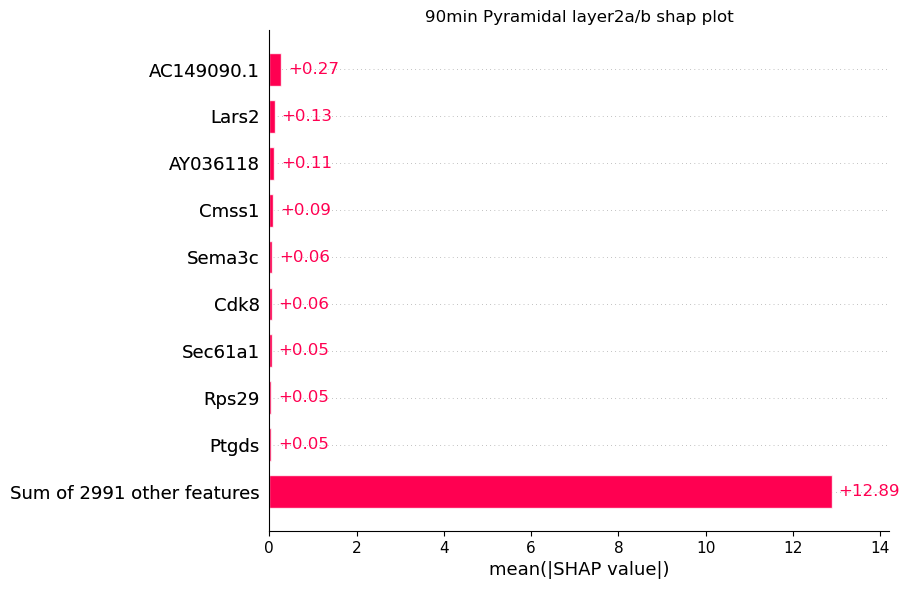

1
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
[0 2 0 2 2 2 2 2 0 1 1 1 1 0 2 0 2 0 2 0 2 2 0 0 2 2 2 2 1 1 2 1 0 0 1 0 0
 1 1 0 1 0 1 2 2 2 2 1 0 2 2 1 2 2 2 0 1 1 2 2 0 1 0 1 2 0 0 2 1 0 0 0 1 0
 2 0 1 2 1 0 0 0 1 0 0 2 0 1 0 2 0 2 0 0 1 1 1 1 0 1 2 0 2 2 1 2 2 1 0 2 0
 0 1 1 2 1 1 0 1 0 2 2 2 2 1 0 2 2 0 1 1 0 0 1 1 0 1 0 0 0 0 1 0 2 1 0 2 0
 0 0 1 1 2 0 1 0 0 2 1 0 2 2 2 2 1 1 1 0 1 0 2 0 0 0 2 1 2 0 0 2 2 0 2 0 2
 0 2 1 2 1 2 0 2 0 2 2 0 0 1 1 2 2 0 1 0 2 1 2 0 0 0 0 2 0 2 2 0 0 1 1 2 2
 2 0 2 2 0 1 2 1 2 0 0 1 0 1 1 2 0 1 2 2 2 0 1 2 2 0 2 2]


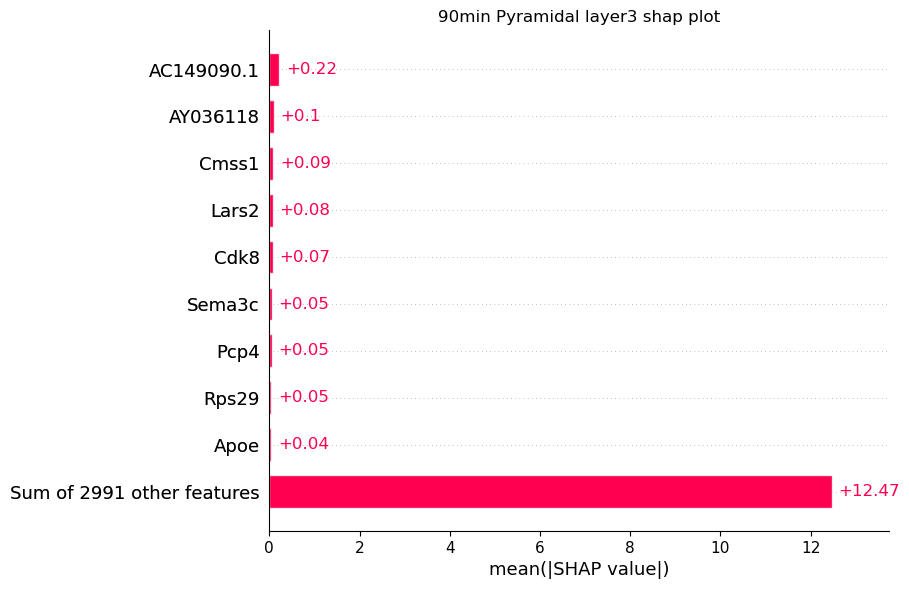

2
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
[1 2 2 2 2 2 2 1 1 1 0 1 0 0 2 2 2 2 2 0 0 2 0 0 0 0 0 2 0 2 0 0 0 2 2 0 0
 1 0 2 2 2 1 1 2 0 0 0 0 0 2 1 1 2 0 0 1 1 2 0 0 0 2 0 2 2 0 2 0 1 2 2 0 0
 0 2 1 2 0 0 0 2 2 0 2 2 1 0 0 0 0 1 0 1 2 0 2 0 2 0 0 1 1 1 2 2 0 2 1 2 0
 2 2 0 2 2 2 0 0 1 1 1 2 0 1 2 1 2 1 1 0 0 1 0 1 1 1 1 1 1 2 2 2 0 0 0 2 0
 0 2 1 1 2 2 1 2 0 0 2 0 2 0 2 0 0 0 2 2 2 1 2 2 2 0 2 2 2 1 0 2 0 1 1 0 0
 0 0 1 2 2 0 1 0 2 2 1 2 2 0 1 0 2 1 0 1 0 0 0 2 2 2 2 2 2 0 1 2 2 1 0 0 2
 1 0 0 1 2 2 2 2 2 2 0 0 0 1 2 2 0 2 0 2 1 2 0 1 0 0 1 0]


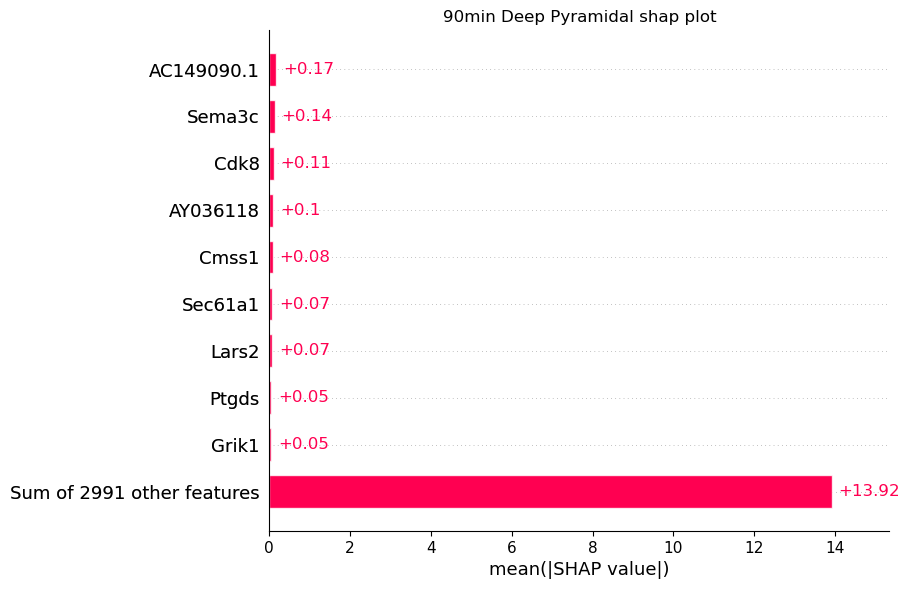

3
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
[1 2 2 2 1 2 1 2 1 2 1 0 0 2 1 1 0 1 0 0 1 1 2 0 0 2 1 2 0 0 2 0 2 2 1 0 0
 0 0 2 1 1 0 0 1 0 1 0 0 2 2 0 2 2 0 0 0 2 0 2 2 1 2 2 1 0 2 2 0 2 2 2 0 2
 0 0 2 2 1 1 2 2 1 0 1 0 0 0 0 0 2 0 2 2 0 0 2 0 2 1 2 0 2 1 0 2 1 2 0 0 2
 2 2 2 0 1 2 2 1 0 0 0 0 0 0 1 2 0 2 0 0 1 0 0 0 0 2 1 1 0 0 2 2 1 0 2 1 1
 0 0 1 1 0 0 0 1 1 0 1 1 2 0 0 0 0 1 2 1 2 2 0 0 0 1 2 0 2 2 2 2 1 1 1 2 0
 2 0 0 2 1 1 2 2 2 1 2 2 0 0 0 0 0 1 0 2 0 0 2 0 0 1 1 0 1 1 0 2 0 0 2 0 1
 1 1 2 2 0 2 0 0 0 0 0 2 0 0 1 2 0 1 0 1 1 0 0 2 2 2 1 1]


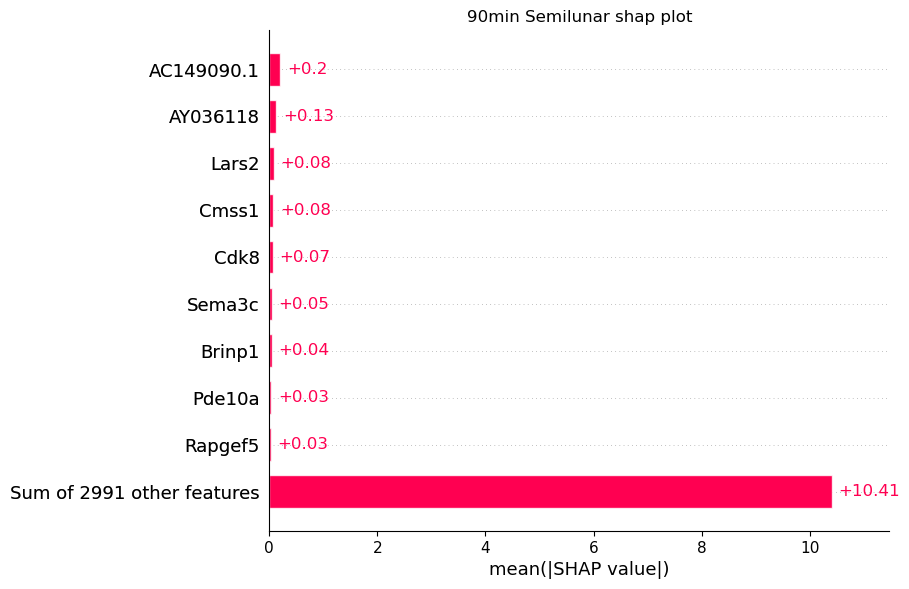

4
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
[0 1 0 1 1 1 2 1 2 0 0 2 2 2 1 1 0 2 2 1 0 2 2 2 2 1 1 2 1 1 0 0 2 1 2 0 1
 0 2 2 2 0 0 1 1 0 0 2 0 0 0 1 2 1 2 2 0 2 0 1 1 1 0 2 2 1 1 0 1 1 0 1 0 0
 2 1 2 2 2 1 0 2 2 0 0 0 2 1 0 0 2 1 0 2 2 0 2 0 1 2 1 0 2 2 0 0 0 2 1 0 2
 0 2 0 2 0 0 1 0 2 0 0 2 2 2 2 1 0 0 0 2 1 1 0 2 0 0 1 1 0 0 1 1 2 0 0 2 1
 0 2 0 1 0 1 0 0 2 2 2 0 0 2 0 2 1 0 1 1 2 0 2 1 1 2 2 0 1 1 2 1 2 0 0 1 2
 0 2 0 1 0 1 0 2 0 2 1 0 1 0 1 2 2 2 2 1 2 0 2 0 0 2 2 0 2 1 2 0 0 2 1 2 0
 0 0 1 0 0 2 2 1 2 2 0 2 1 2 0 0 2 1 2 0 1 0 1 0 1 0 2 2]


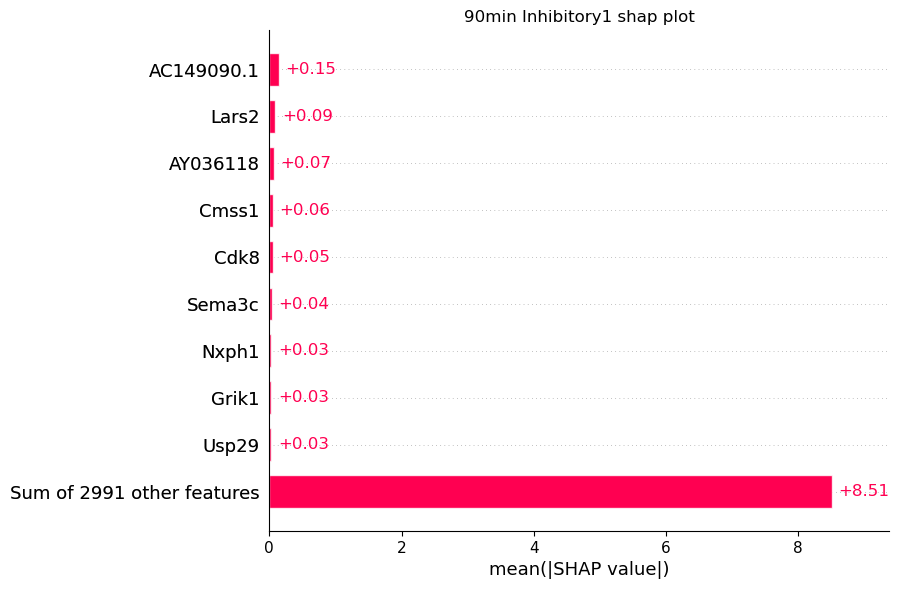

5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
[0 0 1 0 2 1 2 2 0 0 1 1 2 2 1 1 1 1 0 1 2 0 1 1 0 0 2 1 2 0 1 0 0 1 1 0 0
 2 1 1 0 1 2 1 2 1 1 0 1 2 1 0 2 0 1 1 1 1 1 2 2 0 2 0 1 2 0 0 1 2 1 0 0 2
 1 2 2 0 0 1 1 0 2 0 1 1 2 2 0 1 2 0 0 1 0 2 1 2 1 1 1 2 0 1 2 1 2 0 2 0 0
 1 1 1 2 1 2 2 0 1 0 1 1 2 0 0 0 0 0 2 2 1 0 0 0 1 0 0 0 2 1 1 2 2 2 2 1 1
 0 2 1 2 0 0 2 2 1 2 1 0 2 0 0 0 0 2 2 0 0 0 2 0 1 0 0 2 1 0 1 2 1 2 0 2 1
 2 0 1 2 0 1 1 2 1 1 2 0 1 1 1 1 2 0 1 0 1 1 1 0 1 2 1 0 2 0 0 0 2 2 1 1 0
 1 1 2 0 2 2 1 2 0 2 1 0 2 1 0 1 0 2 2 0 0 1 2 2 2 2 1 1]


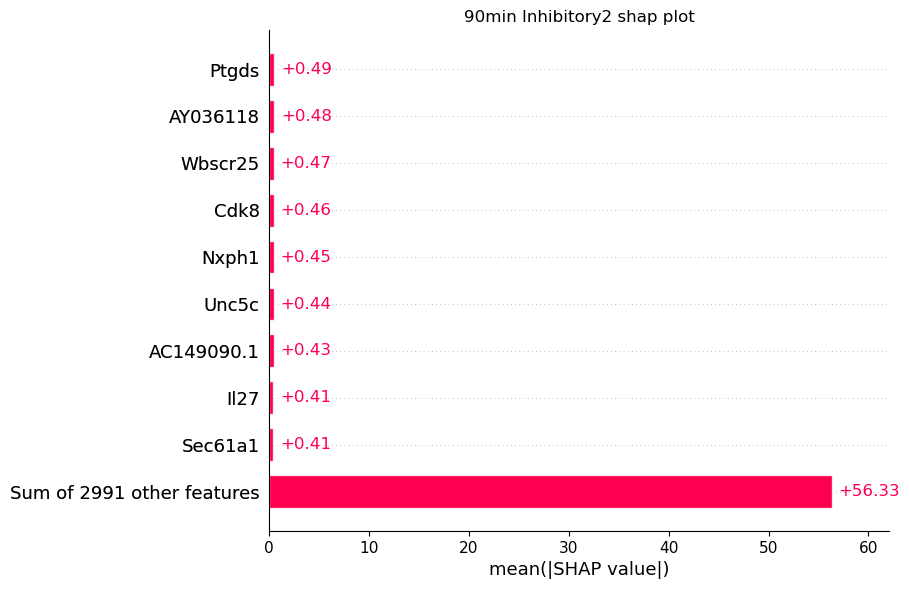

In [11]:
# By leiden cluster: Generate a shap plot

# top50_df = pd.DataFrame()
feature_names = m30_test.var.index.tolist()
cluster_decode = {
    0 : "Pyramidal layer2a/b",
    1 : "Pyramidal layer3",
    2 : "Deep Pyramidal",
    3 : "Semilunar",
    4 : "Inhibitory1",
    5 : "Inhibitory2",
    6 : "Contamination1",
    7 : "Contamination2",
    8 : "Pappa2"
}

def generate_cell_type_shap(which_model, model):
    for j in range(6):
        print(j)
        with open(f'../pickles/{which_model}-data/leiden_cluster_{j}_shap.pkl', 'rb') as f:
            leiden_shap = pickle.load(f)
        with open(f'../pickles/{which_model}-data/leiden_cluster_{j}_shap_data_subset.pkl', 'rb') as f:
            leiden_shap_sample = pickle.load(f)
        
        shap_vals = np.squeeze(leiden_shap)
        
        preds = model.predict(leiden_shap_sample)
        preds = np.argmax(tf.nn.softmax(preds, axis = 1), axis = 1)
        print(preds)
        
        new_shap_vals = []
        for i, pred in enumerate(preds):
            new_shap_vals.append(shap_vals[i][:, pred])
        
        new_shap_vals = np.array(new_shap_vals)
        
        explanation = shap.Explanation(new_shap_vals, feature_names = feature_names)
    
        # Extract the mean absolute SHAP values for each feature
        mean_abs_shap_vals = np.mean(np.abs(explanation.values), axis=0)
        
        # Get the indices of the top 110 features
        top_100_indices = np.argsort(mean_abs_shap_vals)[-101:][::-1]
        
        # Extract the feature names for the top 110 features
        top_100_features = [explanation.feature_names[i] for i in top_100_indices]
    
        # top100_df[f'{cluster_decode[j]}'] = top_100_features
        
    
        shap.plots.bar(explanation, max_display = 10, show = False)
        plt.title(f'{which_model} {cluster_decode[j]} shap plot')
        plt.show()
generate_cell_type_shap("30min", model30)
generate_cell_type_shap("90min", model90)

In [16]:
print(top100_df)

    Aggregate SHAP Pyramidal layer2a/b Pyramidal layer3 Deep Pyramidal  \
0            Lars2            AY036118       AC149090.1     AC149090.1   
1       AC149090.1               Lars2             Cdk8       AY036118   
2             Cdk8          AC149090.1            Lars2          Lars2   
3         AY036118                Cdk8         AY036118          Cmss1   
4            Cmss1               Cmss1            Cmss1           Cdk8   
..             ...                 ...              ...            ...   
96           Pdzd2                 Mt1            Stmn1          Vsnl1   
97           Erbb4                Ahi1              Mt1          Kcnd2   
98            Nrgn               Vamp2            Rps21         Cox4i1   
99          Rpl37a               Megf9            Ndst4         Brinp3   
100          Atp5k               Rps21             Eps8           Wwc1   

      Semilunar Inhibitory1 Inhibitory2  
0    AC149090.1    AY036118       Lars2  
1         Lars2  AC149090.1

0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
[4 0 0 0 0 0 2 0 0 0 0 0 0 0 0 3 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 3 0 0 5
 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 1 0 1 0
 0 0 0 0 0 0 4 0 3 0 0 0 0 0 0 3 0 3 0 0 0 1 0 0 0 0]


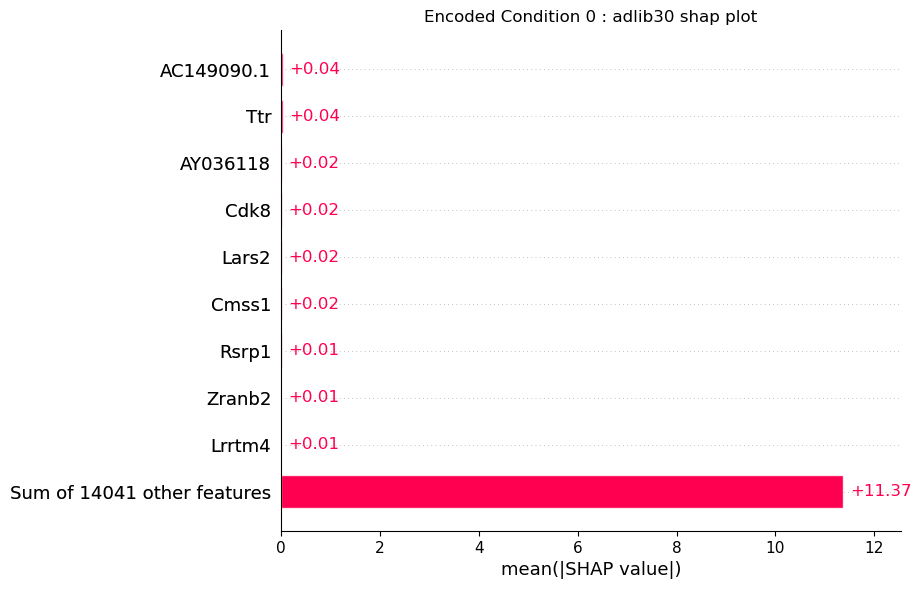

1
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
[4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 7 1 1 1 1 1 1 1 1 1 7 1 1 4
 1 1 1 4 1 1 7 1 1 1 2 1 4 4 1 3 1 1 1 5 4 1 1 1 4 1 1 1 1 1 1 1 4 1 1 2 1
 1 1 1 1 1 1 5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


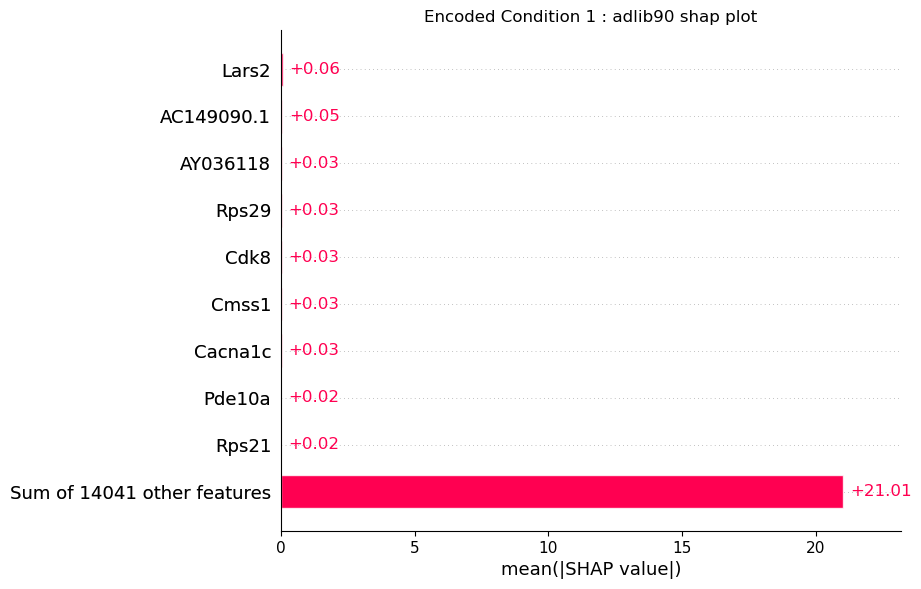

2
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
[2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2
 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 7]


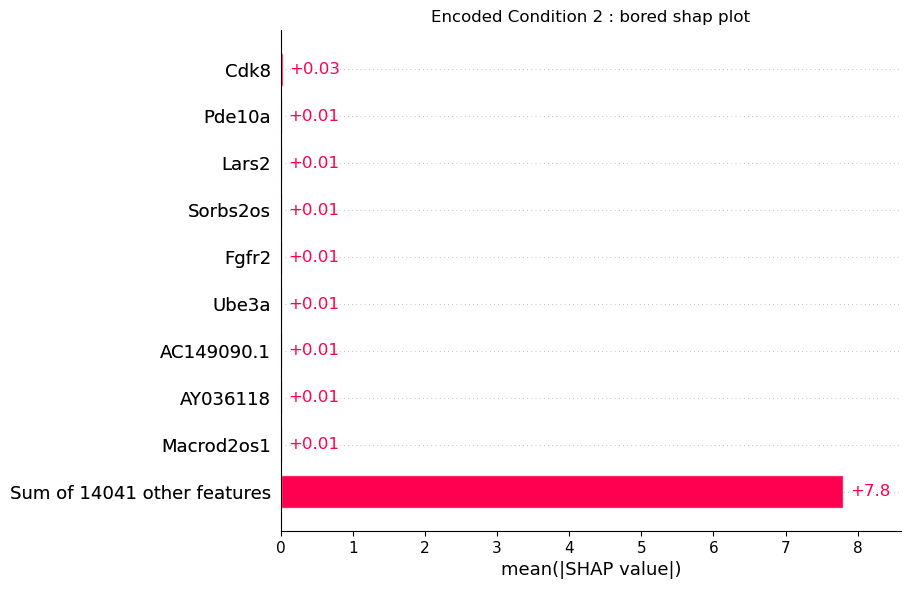

3
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
[3 7 7 7 3 7 3 3 0 7 3 3 3 7 3 7 3 3 3 7 3 3 3 3 3 3 3 3 3 3 7 7 3 3 7 3 3
 3 3 7 3 3 3 3 7 3 3 3 3 3 3 3 3 7 3 3 7 3 3 3 3 7 7 3 7 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 4 3 7 3 7 3 3 7 3 3 7 3 7 3 7 3 3 7]


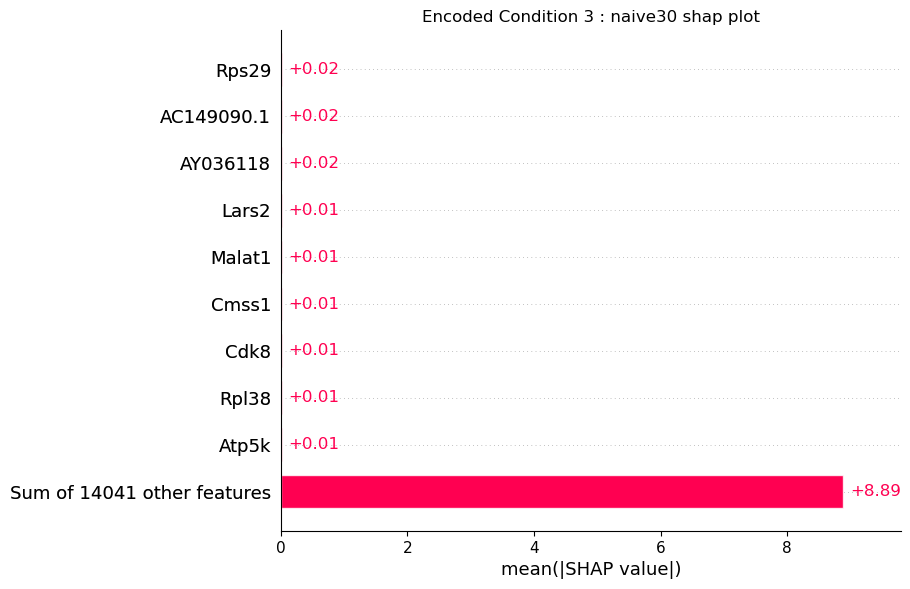

4
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
[4 0 2 1 4 4 4 4 1 4 4 2 4 4 4 4 8 4 1 3 4 7 4 4 4 1 4 1 4 5 4 1 1 4 1 4 2
 4 4 4 4 4 4 4 4 4 5 4 4 1 4 4 4 4 4 1 3 4 4 3 0 4 4 5 4 4 2 1 4 8 4 4 5 4
 4 4 4 4 4 4 4 4 4 4 4 4 1 4 4 4 4 5 4 1 4 4 4 4 4 4]


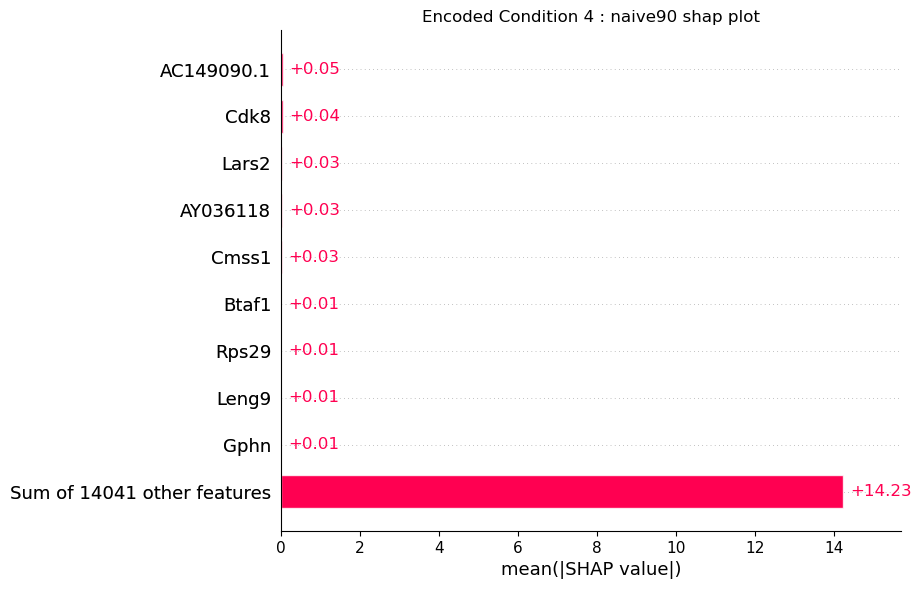

5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
[1 5 5 5 4 5 5 5 5 5 0 5 5 5 5 1 5 5 5 5 5 5 5 5 5 5 1 5 0 5 5 5 5 5 5 5 5
 5 0 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 2 5 5 5 5 8 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 4 5 5 1 5 7 5 5 5 5 5 5 5 5 5 5 1 5 5 5 5]


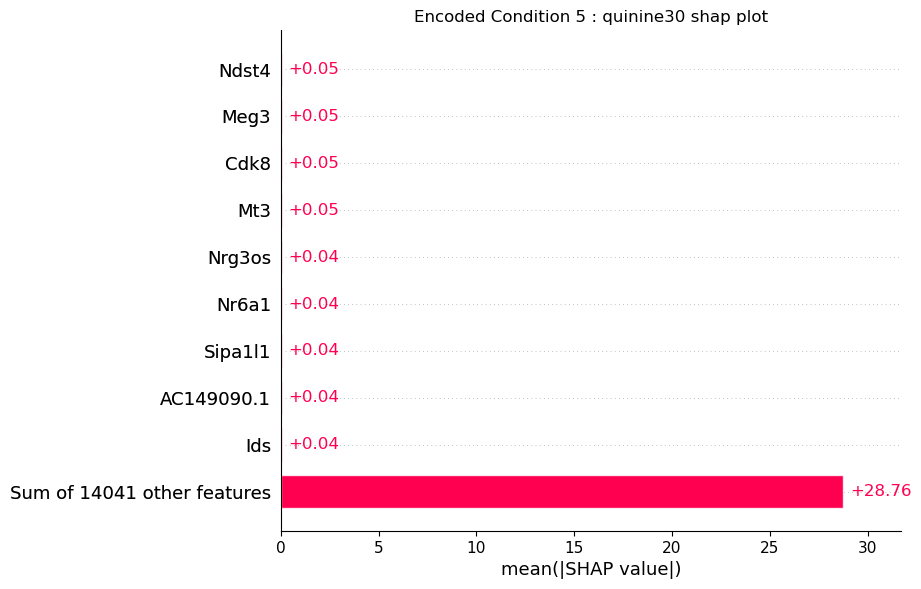

6
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
[6 6 6 6 6 6 6 6 6 6 6 6 6 8 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 4
 6 6 6 6 6 6 6 6 6 6 3 6 6 6 8 6 6 7 6 6 6 6 7 6 6 7 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 7 6 6 6 6 6 6 6 6 7 6 6 6 7 8 6 7 7 6 6]


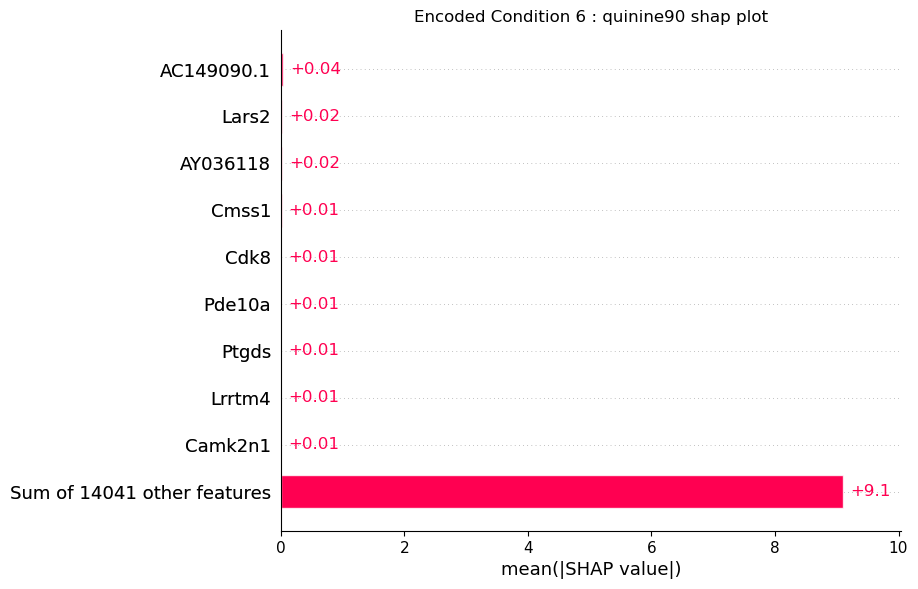

7
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
[7 7 7 7 7 7 7 7 7 3 7 3 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 3 7 7 5 7
 5 7 7 7 7 7 3 3 7 7 7 7 7 7 7 5 3 7 7 7 7 7 7 7 0 7 7 7 4 7 7 7 3 7 7 7 3
 7 7 7 7 7 7 7 7 7 7 7 7 7 3 7 7 7 7 7 7 7 7 7 5 7 7]


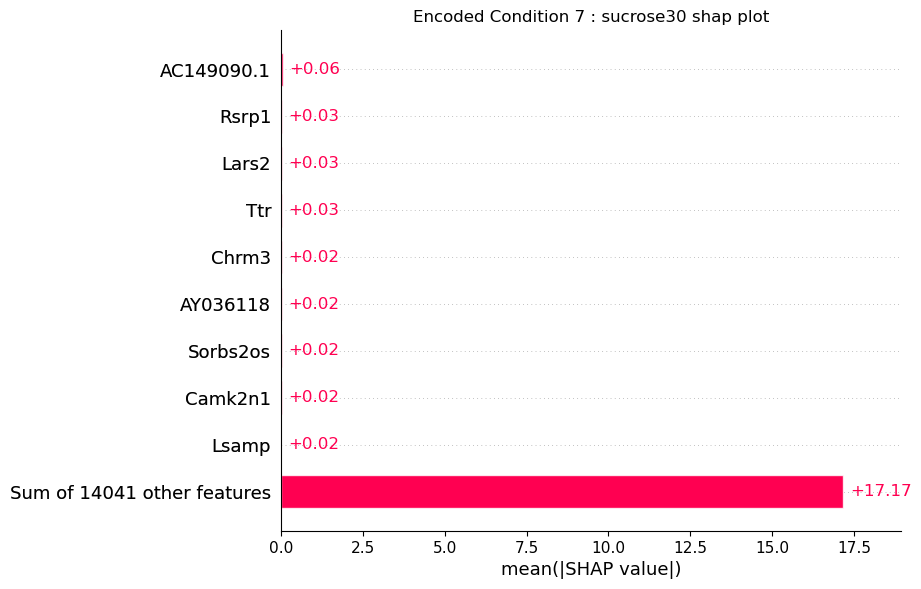

8
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
[8 8 8 8 8 8 8 8 8 8 8 8 8 8 6 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 6 6 8 8 8 8 8 8 8 8 8 8 1 8 8 8 6 4 8
 8 8 8 8 8 8 8 8 8 8 7 8 8 8 8 8 8 8 8 6 8 8 8 8 8 8]


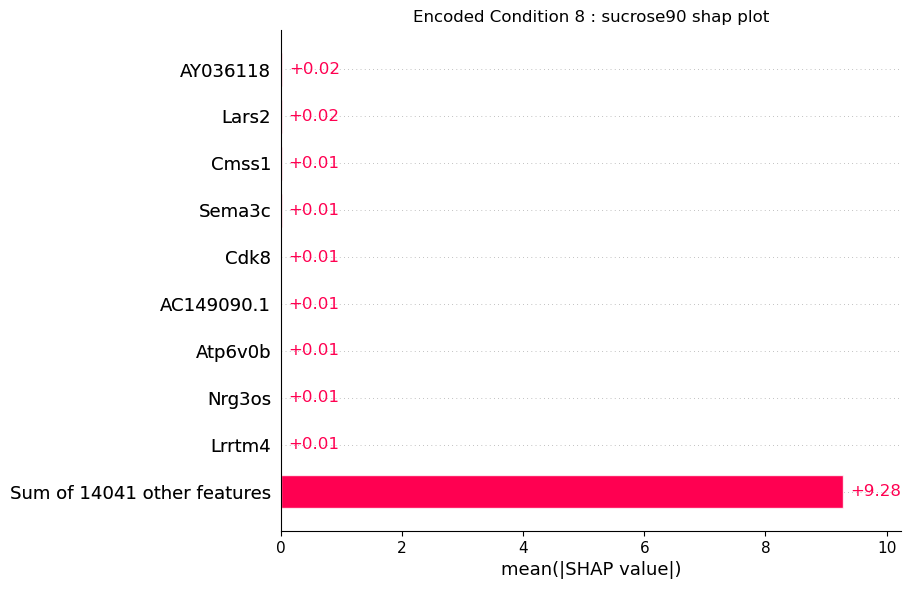

In [17]:
for j in range(9):
    print(j)
    with open(f'encoded_condition_{j}_shap.pkl', 'rb') as f:
        leiden_shap = pickle.load(f)
    with open(f'encoded_condition_{j}_shap_data_subset.pkl', 'rb') as f:
        leiden_shap_sample = pickle.load(f)
    
    shap_vals = np.squeeze(leiden_shap)
    
    preds = model.predict(leiden_shap_sample)
    preds = np.argmax(tf.nn.softmax(preds, axis = 1), axis = 1)
    print(preds)
    
    new_shap_vals = []
    for i, pred in enumerate(preds):
        new_shap_vals.append(shap_vals[i][:, pred])
    
    new_shap_vals = np.array(new_shap_vals)
    
    explanation = shap.Explanation(new_shap_vals, feature_names = feature_names)

    # Extract the mean absolute SHAP values for each feature
    mean_abs_shap_vals = np.mean(np.abs(explanation.values), axis=0)
    
    # Get the indices of the top 110 features
    top_100_indices = np.argsort(mean_abs_shap_vals)[-101:][::-1]
    
    # Extract the feature names for the top 110 features
    top_100_features = [explanation.feature_names[i] for i in top_100_indices]
    
    top100_df[condition_mapping.loc[j, 'Original Condition']] = top_100_features
    
    shap.plots.bar(explanation, max_display = 10, show = False)
    plt.title(f'Encoded Condition {j} : {condition_mapping.loc[j, "Original Condition"]} shap plot')
    plt.show()

In [19]:
top100_df.to_csv('top_100_features_new.csv', index=False)

In [18]:
top100_df

Aggregate SHAP Pyramidal layer2a/b Pyramidal layer3 Deep Pyramidal  \
0            Lars2            AY036118       AC149090.1     AC149090.1   
1       AC149090.1               Lars2             Cdk8       AY036118   
2             Cdk8          AC149090.1            Lars2          Lars2   
3         AY036118                Cdk8         AY036118          Cmss1   
4            Cmss1               Cmss1            Cmss1           Cdk8   
..             ...                 ...              ...            ...   
96           Pdzd2                 Mt1            Stmn1          Vsnl1   
97           Erbb4                Ahi1              Mt1          Kcnd2   
98            Nrgn               Vamp2            Rps21         Cox4i1   
99          Rpl37a               Megf9            Ndst4         Brinp3   
100          Atp5k               Rps21             Eps8           Wwc1   

      Semilunar Inhibitory1 Inhibitory2     adlib30     adlib90     bored  \
0    AC149090.1    AY036118       Lars2  AC149090.1       Lars2      Cdk8   
1         Lars2  AC149090.1  AC149090.1         Ttr  AC149090.1    Pde10a   
2          Cdk8       Lars2    AY036118    AY036118    AY036118     Lars2   
3      AY036118       Cmss1        Cdk8        Cdk8       Rps29  Sorbs2os   
4         Cmss1        Cdk8       Cmss1       Lars2        Cdk8     Fgfr2   
..          ...         ...         ...         ...         ...       ...   
96        Auts2      Spred2         Fus        Pigk       Sez6l    Rimbp2   
97     Il1rapl1      Lrrtm4       Nptxr       Slit3        Sik3      Klf7   
98        Ndrg4       Hecw2       Gria1        Dpp6       Ttll7      Syt7   
99      Slc2a13      Galnt1       Ndst4     Slc4a10      Dpysl2    Otud7a   
100     Atp6v0c      Camk1d        Nrg1        Rps2      Dlgap1     Vamp2   

        naive30     naive90 quinine30   quinine90   sucrose30 sucrose90  
0         Rps29  AC149090.1     Ndst4  AC149090.1  AC149090.1  AY036118  
1    AC149090.1        Cdk8      Meg3       Lars2       Rsrp1     Lars2  
2      AY036118       Lars2      Cdk8    AY036118       Lars2     Cmss1  
3         Lars2    AY036118       Mt3       Cmss1         Ttr    Sema3c  
4        Malat1       Cmss1    Nrg3os        Cdk8       Chrm3      Cdk8  
..          ...         ...       ...         ...         ...       ...  
96        Pnisr       Rab3c     Lsamp       Cdyl2       Fbxl5     Alcam  
97         Nmt2      Dnajc1  Mir670hg       Camk4      Nrg3os     Rpl41  
98      Epb41l1       Gria1     Ifi35       Ctxn1    Mir9-3hg     Rpl21  
99         Pld3      Snhg11     Larp1      Sorcs2        Agrp  Cntnap5a  
100         Cck     Sec61a1    Sez6l2       Lrp1b      Immp1l     Cplx2  

[101 rows x 16 columns]

# Heatmap (x = cell type, y = top50 genes)

In [8]:
import pandas as pd

cluster_decode = {
    0 : "Pyramidal layer2a/b",
    1 : "Pyramidal layer3",
    2 : "Deep Pyramidal",
    3 : "Semilunar",
    4 : "Inhibitory1",
    5 : "Inhibitory2",
    6 : "Contamination1",
    7 : "Contamination2",
    8 : "Pappa2"
}






# Read in top 50 features for each cell type, find union of all top 50 features
top_50df = pd.read_csv('top_100_features_new.csv')
top_50_union = {}
for i in X_test.obs['leiden'].unique():
    print(f"Leiden cluster: {i}")
    cluster_samples = X_test[X_test.obs['leiden'] == i]
    # print(cluster_samples)
    for j in range(len(top_50df[cluster_decode[int(i)]])):
        if j < 50:
            if i not in top_50_union:
                top_50_union[top_50df[cluster_decode[int(i)]][j]] = 0
            top_50_union[top_50df[cluster_decode[int(i)]][j]] += 1
        else: 
            continue
union50 = sorted(list(top_50_union.keys()), reverse = True,  key = lambda x : top_50_union[x])

union50csv = pd.DataFrame()

union50csv['union50'] = union50


union50csv.to_csv('top_101_features.csv', index=False)
# union50 = union50[:50]



Leiden cluster: 3
Leiden cluster: 6
Leiden cluster: 2
Leiden cluster: 1
Leiden cluster: 8
Leiden cluster: 0
Leiden cluster: 4
Leiden cluster: 5
Leiden cluster: 7


In [18]:
cluster_decode = {
    0 : "Pyramidal layer2a/b",
    1 : "Pyramidal layer3",
    2 : "Deep Pyramidal",
    3 : "Semilunar",
    4 : "Inhibitory1",
    5 : "Inhibitory2",
    6 : "Contamination1",
    7 : "Contamination2",
    8 : "Pappa2"
}
# Step 1: Read the CSV file into a Pandas DataFrame
df = pd.read_csv('top_50_features_new.csv')
df = df[[cluster_decode[int(x)] for x in X_test.obs['leiden'].unique()]]
df = df.head(50)

# Step 2: Combine all columns into one mega column (flattening)
mega_column = pd.Series(df.values.ravel()).drop_duplicates().reset_index(drop=True)

# # Step 3: Remove duplicates and drop NaN values (if any)
mega_column_unique = mega_column.drop_duplicates().dropna()

# Optionally convert it back into a DataFrame with one column
df_mega = pd.DataFrame(mega_column_unique, columns=['Mega_Column'])

# Step 4: Save or print the result

df_mega.to_csv('output.csv', index=False)
union50= list(mega_column)
union50 = [x for x in union50 if x != "Malat1"]

In [35]:
# print(mega_column)
# union50 = [gene for gene in mega_column if not (gene.startswith('Gm') or gene.startswith('mt-') or 'Rik' in gene)][:51]
# print(union50)
# print(len(union50))

0         Gm42418
1      AC149090.1
2           Lars2
3            Cdk8
4        AY036118
          ...    
160         Rps18
161       Cacna1c
162         Kcnn3
163       Gm11417
164         Rgs17
Length: 165, dtype: object
['AC149090.1', 'Lars2', 'Cdk8', 'AY036118', 'Ttr', 'Malat1', 'Cmss1', 'Spred2', 'Rps21', 'Ptgds', 'Brinp2', 'Son', 'Rps29', 'Pde10a', 'Lrrtm4', 'Rbfox1', 'Nptxr', 'Gfod1', 'Phactr1', 'Adarb2', 'Zranb2', 'Sema3c', 'Dpp10', 'Atp6v0b', 'Trim9', 'Rps28', 'Brd9', 'Myt1l', 'Atp6v0c', 'Btaf1', 'Sorbs2os', 'Gphn', 'Hivep2', 'Gpc5', 'Scn2a', 'Erbb4', 'Camk1d', 'Ide', 'Apoe', 'Cst3', 'Grip1', 'Kcnma1', 'Nrg3os', 'Lncpint', 'Nxph1', 'Ubash3b', 'Ncam2', 'Camk2n1', 'Cox7c', 'Tafa1', 'Rpl37']
51


In [9]:
order_conversion = {
    2: 0, 
    3: 1, 
    4: 2,
    0: 3, 
    1: 4, 
    7: 5, 
    8: 6, 
    5: 7, 
    6: 8, 
}
order_conversion = order_conversion.keys()
print(order_conversion)

dict_keys([2, 3, 4, 0, 1, 7, 8, 5, 6])


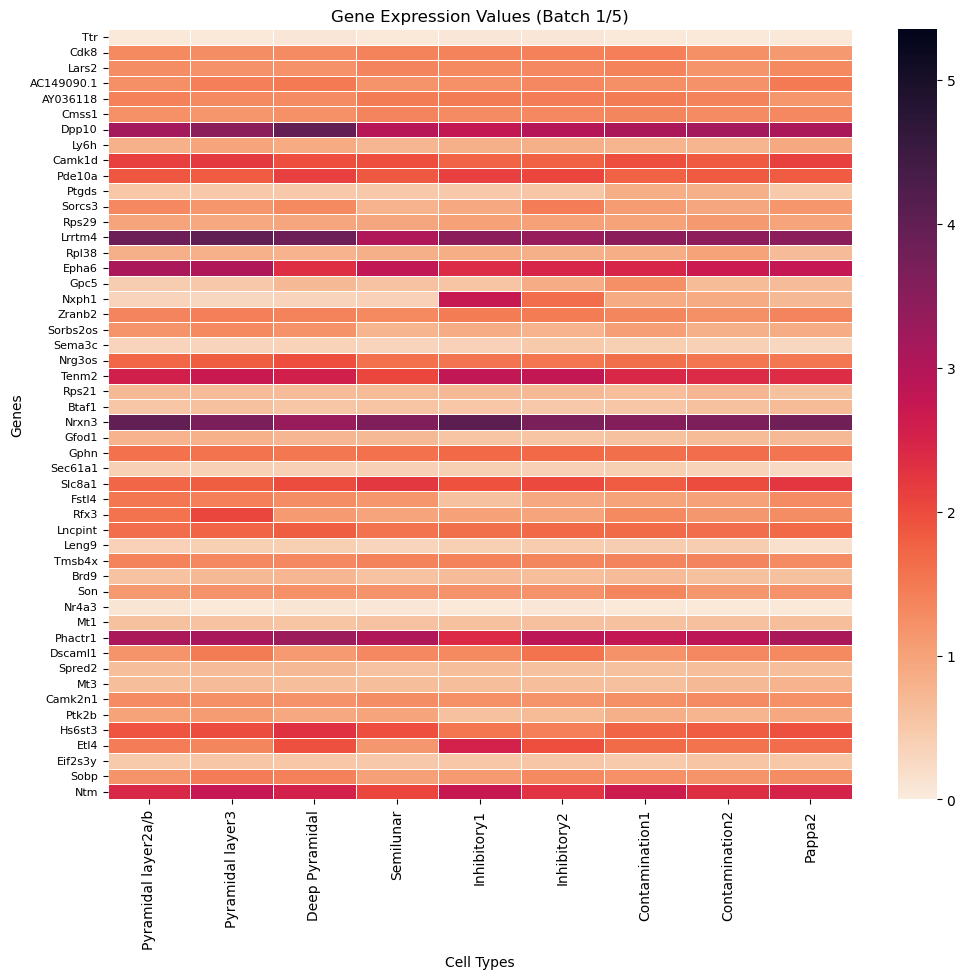

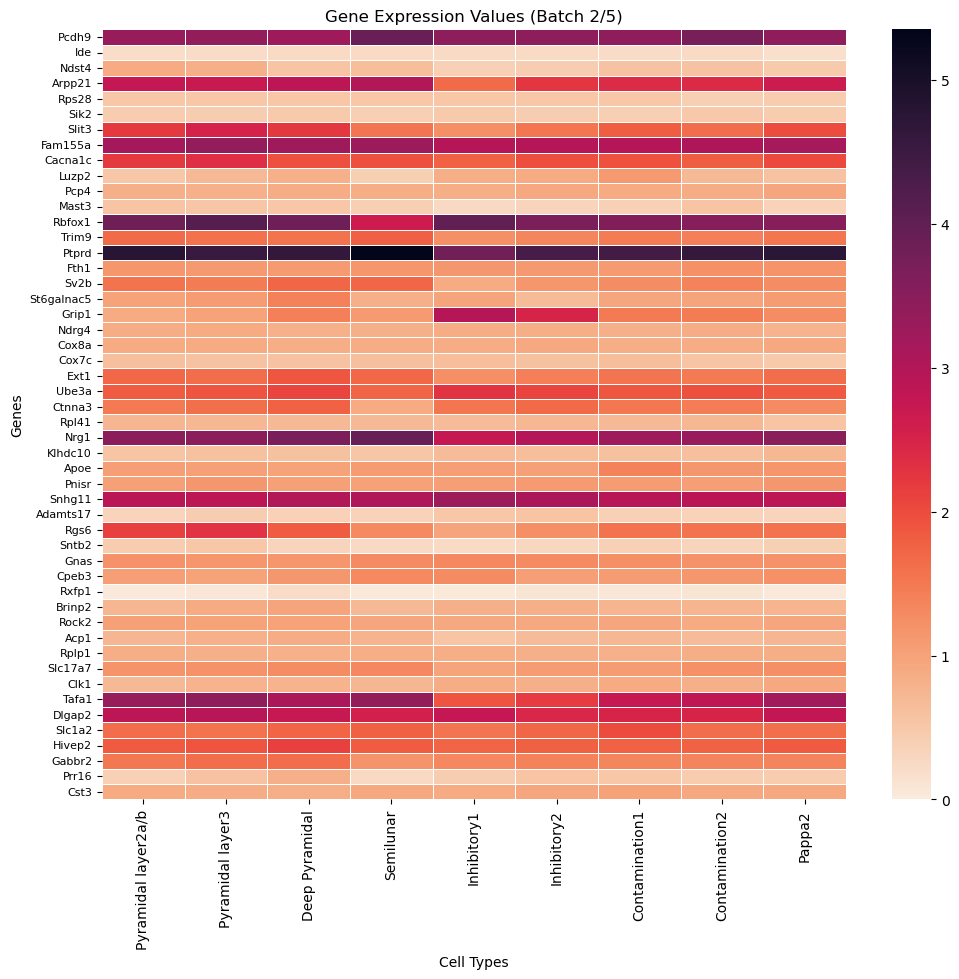

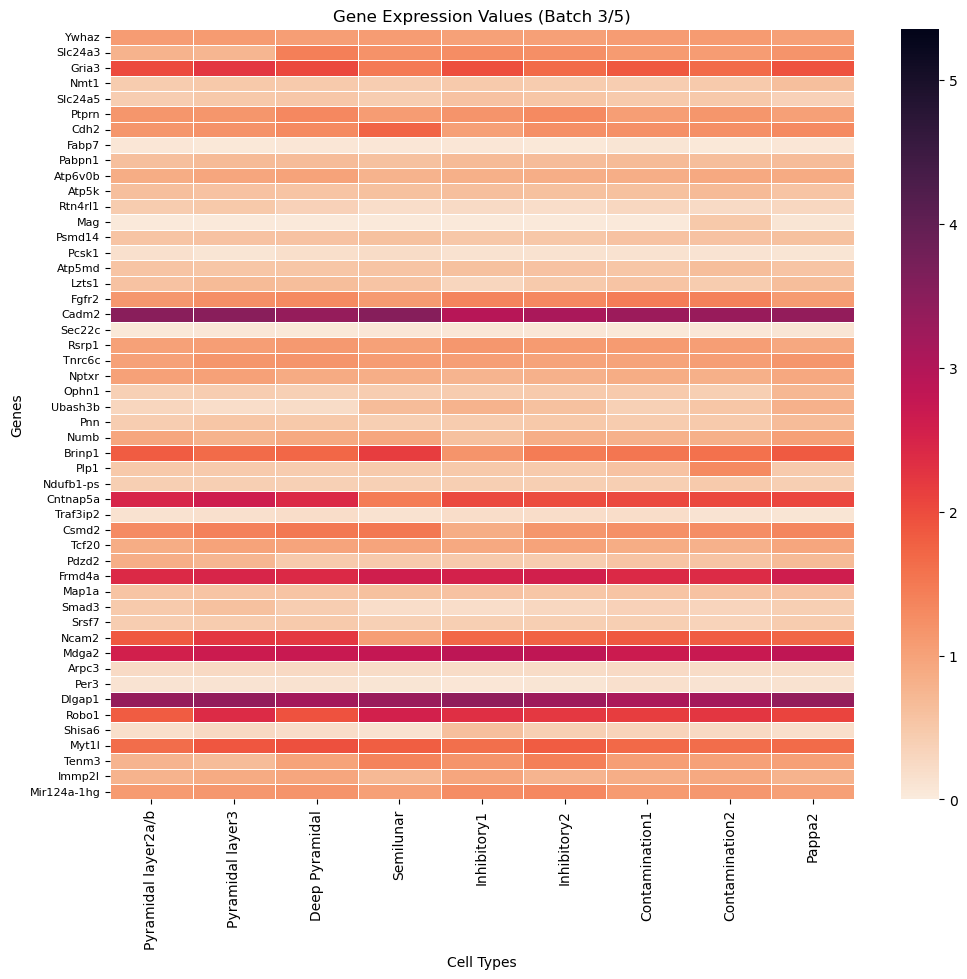

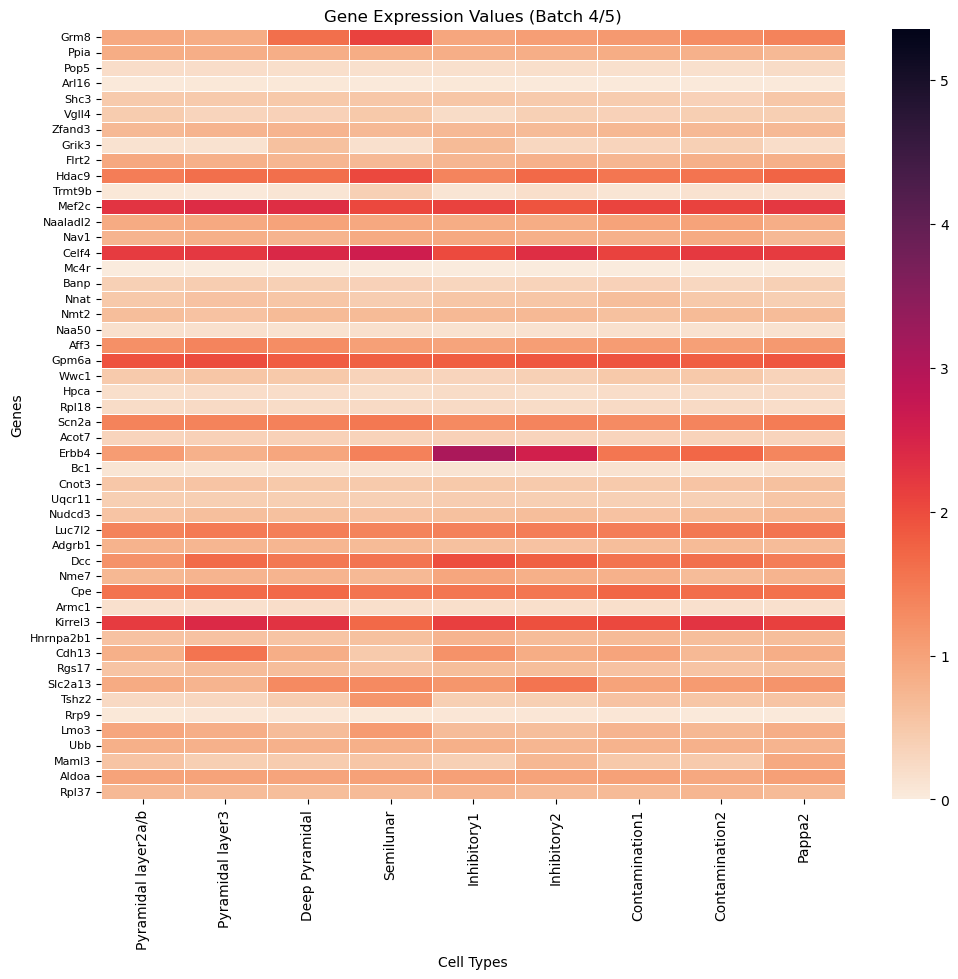

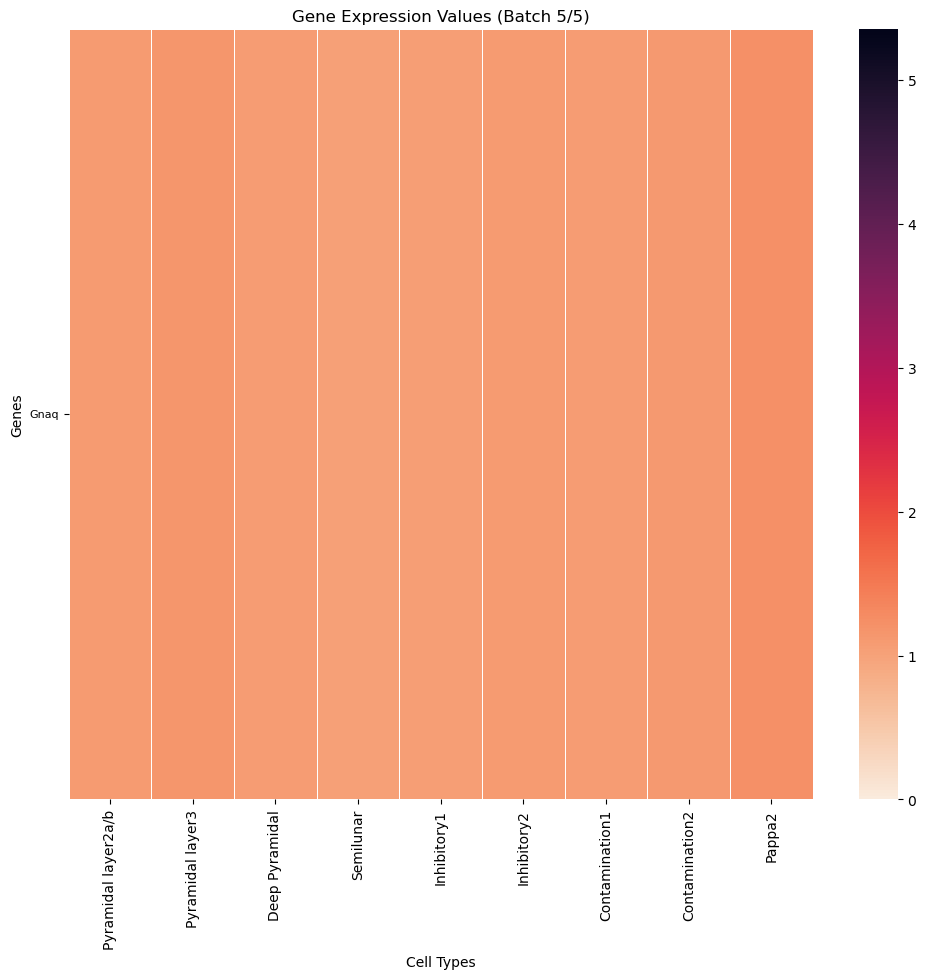

In [20]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# import pandas as pd
# import numpy as np

# batch_size = 50  # Number of genes per batch
# num_batches = len(union50) // batch_size + (1 if len(union50) % batch_size != 0 else 0)

# Step 1: Find global min and max expression values across all batches
global_min, global_max = np.inf, -np.inf

for batch_idx in range(num_batches):
    gene_batch = union50[batch_idx * batch_size : (batch_idx + 1) * batch_size]
    raw_data_df = pd.DataFrame(index=gene_batch)

    # Explicitly maintain column order
    columns_order = []

    for i in range(9):

        i = str(i)
        cluster_samples = X_test[X_test.obs['leiden'] == i]
        cluster_values = []

        for gene in gene_batch:
            gene_index = None
            if gene in cluster_samples.var.index:
                gene_index = cluster_samples.var.index.get_loc(gene)
            
            if gene_index is None:
                cluster_values.append(0)
                continue

            gene_expression_values = cluster_samples.raw[:, gene_index].X
            mean_expression = np.mean(gene_expression_values)
            
            cluster_values.append(mean_expression)

        # Maintain column order by appending each cluster's name to the list
        column_name = cluster_decode[int(i)]
        raw_data_df[column_name] = cluster_values
        columns_order.append(column_name)  # Track the column order

    # Reorder the DataFrame columns to preserve the order in which they were added
    raw_data_df = raw_data_df[columns_order]
    
    # Update global min and max
    global_min = min(global_min, raw_data_df.min().min())
    global_max = max(global_max, raw_data_df.max().max())

# Step 2: Plot heatmaps with shared scale
for batch_idx in range(num_batches):
    gene_batch = union50[batch_idx * batch_size : (batch_idx + 1) * batch_size]
    raw_data_df = pd.DataFrame(index=gene_batch)

    # Explicitly maintain column order
    columns_order = []

    for i in range(9):
        i = str(i)
        cluster_samples = X_test[X_test.obs['leiden'] == i]
        cluster_values = []

        for gene in gene_batch:
            gene_index = None
            if gene in cluster_samples.var.index:
                gene_index = cluster_samples.var.index.get_loc(gene)
            
            if gene_index is None:
                cluster_values.append(0)
                continue

            gene_expression_values = cluster_samples.raw[:, gene_index].X
            mean_expression = np.mean(gene_expression_values)
            
            cluster_values.append(mean_expression)

        column_name = cluster_decode[int(i)]
        raw_data_df[column_name] = cluster_values
        columns_order.append(column_name)

    # Ensure column order remains consistent
    raw_data_df = raw_data_df[columns_order]

    raw_data_df = raw_data_df.apply(pd.to_numeric, errors='coerce').fillna(0).astype(float)

    # Generate heatmap for the current batch using global min and max
    plt.figure(figsize=(12, 10))
    sns.heatmap(raw_data_df, annot=False, cmap="rocket_r", linewidths=.5, vmin=global_min, vmax=global_max)

    plt.title(f'Gene Expression Values (Batch {batch_idx + 1}/{num_batches})')
    plt.xlabel("Cell Types")
    plt.ylabel("Genes")
    
    plt.yticks(rotation=0, fontsize=8)

    # Show the plot for each batch
    plt.show()



# import seaborn as sns
# import matplotlib.pyplot as plt

# raw_data_df = pd.DataFrame(index=union50 )


# for i in X_test.obs['leiden'].unique():
#     print(f"Leiden cluster: {i}")
#     cluster_samples = X_test[X_test.obs['leiden'] == i]
#     cluster_values = []

#     # print(cluster_samples.var['gene_ids'])

#     for gene in union50:
#         # Find the matching Ensembl ID
#         # print(cluster_samples.var['gene_ids'])
#         # if 'Gm' in gene[0:2] or 'mt-' in gene[0:3] or 'Rik' in gene:
#         #     continue
#         gene_index = None
#         if gene in cluster_samples.var.index:
#             gene_index = cluster_samples.var.index.get_loc(gene)
#         # print(gene_index)
        
#         if gene_index is None:
#             cluster_values.append(0)  # Append 0 if gene not found
#             continue
#         # print(gene_index)
#         # Get raw gene expression data for the selected cluster and gene
#         gene_expression_values = cluster_samples.raw[:, gene_index].X
#         # print(gene_expression_values)
#         # Compute the mean expression value across all samples for this gene
#         mean_expression = np.mean(gene_expression_values)
        
#         cluster_values.append(mean_expression)

#     # Store the averaged values for this cluster
#     raw_data_df[cluster_decode[int(i)]] = cluster_values
    
# # Step 1: Convert all data to numeric
# raw_data_df = raw_data_df.apply(pd.to_numeric, errors='coerce')

# # Step 2: Handle NaN values
# raw_data_df.fillna(0, inplace=True)

# # Step 3: Convert the DataFrame to float
# raw_data_df = raw_data_df.astype(float)

# # # Create a heatmap using seaborn
# # plt.figure(figsize=(10, 6))
# # sns.heatmap(raw_data_df, annot=False, cmap="vlag", linewidths=.5)

# # # Adding labels and title
# # plt.title("Heatmap of Gene Expression")
# # plt.xlabel("Cell Types")
# # plt.ylabel("Genes")

# # # Show the plot
# # plt.show()

# plt.figure(figsize=(12, 10))
# sns.heatmap(raw_data_df, annot=False, cmap="rocket_r", linewidths=.5)

# plt.title(f'Gene Expression Values')
# plt.xlabel("Cell Types")
# plt.ylabel("Genes")

# # Rotate the y-axis labels if needed
# plt.yticks(rotation=0, fontsize=8)  # Adjust fontsize as needed

# plt.show()




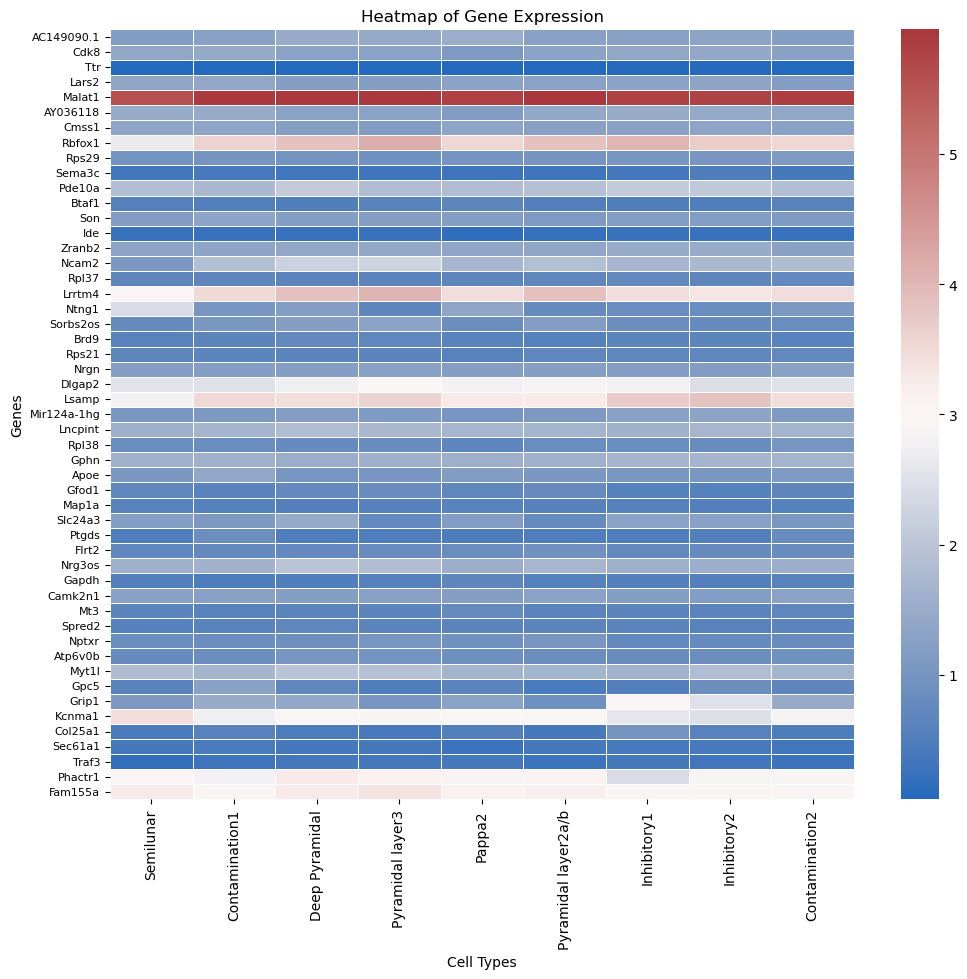

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Convert all data to numeric
raw_data_df = raw_data_df.apply(pd.to_numeric, errors='coerce')

# Step 2: Handle NaN values
raw_data_df.fillna(0, inplace=True)

# Step 3: Convert the DataFrame to float
raw_data_df = raw_data_df.astype(float)

# # Create a heatmap using seaborn
# plt.figure(figsize=(10, 6))
# sns.heatmap(raw_data_df, annot=False, cmap="vlag", linewidths=.5)

# # Adding labels and title
# plt.title("Heatmap of Gene Expression")
# plt.xlabel("Cell Types")
# plt.ylabel("Genes")

# # Show the plot
# plt.show()

plt.figure(figsize=(12, 10))
sns.heatmap(raw_data_df, annot=False, cmap="vlag", linewidths=.5)

plt.title("Heatmap of Gene Expression")
plt.xlabel("Cell Types")
plt.ylabel("Genes")

# Rotate the y-axis labels if needed
plt.yticks(rotation=0, fontsize=8)  # Adjust fontsize as needed

plt.show()

In [ ]:
for i in raw_data_df:
    for j, gene in enumerate(raw_data_df[i]):

        if abs(gene) > 1: 
            print(f'{i}, {union50[j]}, {gene}')

# GO